In [78]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from typing import Tuple
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from scipy.linalg import svd, qr
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score
import statsmodels.api as sm
from numpy.polynomial.hermite import hermval
from sklearn.linear_model import lasso_path
from sklearn.model_selection import KFold
import scipy.linalg
from scipy.linalg import diagsvd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18  # Adjust x-axis tick label size
plt.rcParams['ytick.labelsize'] = 18  # Adjust y-axis tick label size

# Set seed for reproducibility.
np.random.seed(0)

In [44]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

In [7]:
X = X.replace("?", np.nan)
X = X.drop(columns = ['fold', 'county', 'community', 'communityname', 'state'])
X = X.apply(pd.to_numeric, errors='coerce')

In [8]:
y_arr = np.array(y['ViolentCrimesPerPop'])

## EDA

In [9]:
na_proportion = X.isna().mean()
na_proportion

population             0.00000
householdsize          0.00000
racepctblack           0.00000
racePctWhite           0.00000
racePctAsian           0.00000
                        ...   
PolicOperBudg          0.84002
LemasPctPolicOnPatr    0.84002
LemasGangUnitDeploy    0.84002
LemasPctOfficDrugUn    0.00000
PolicBudgPerPop        0.84002
Length: 122, dtype: float64

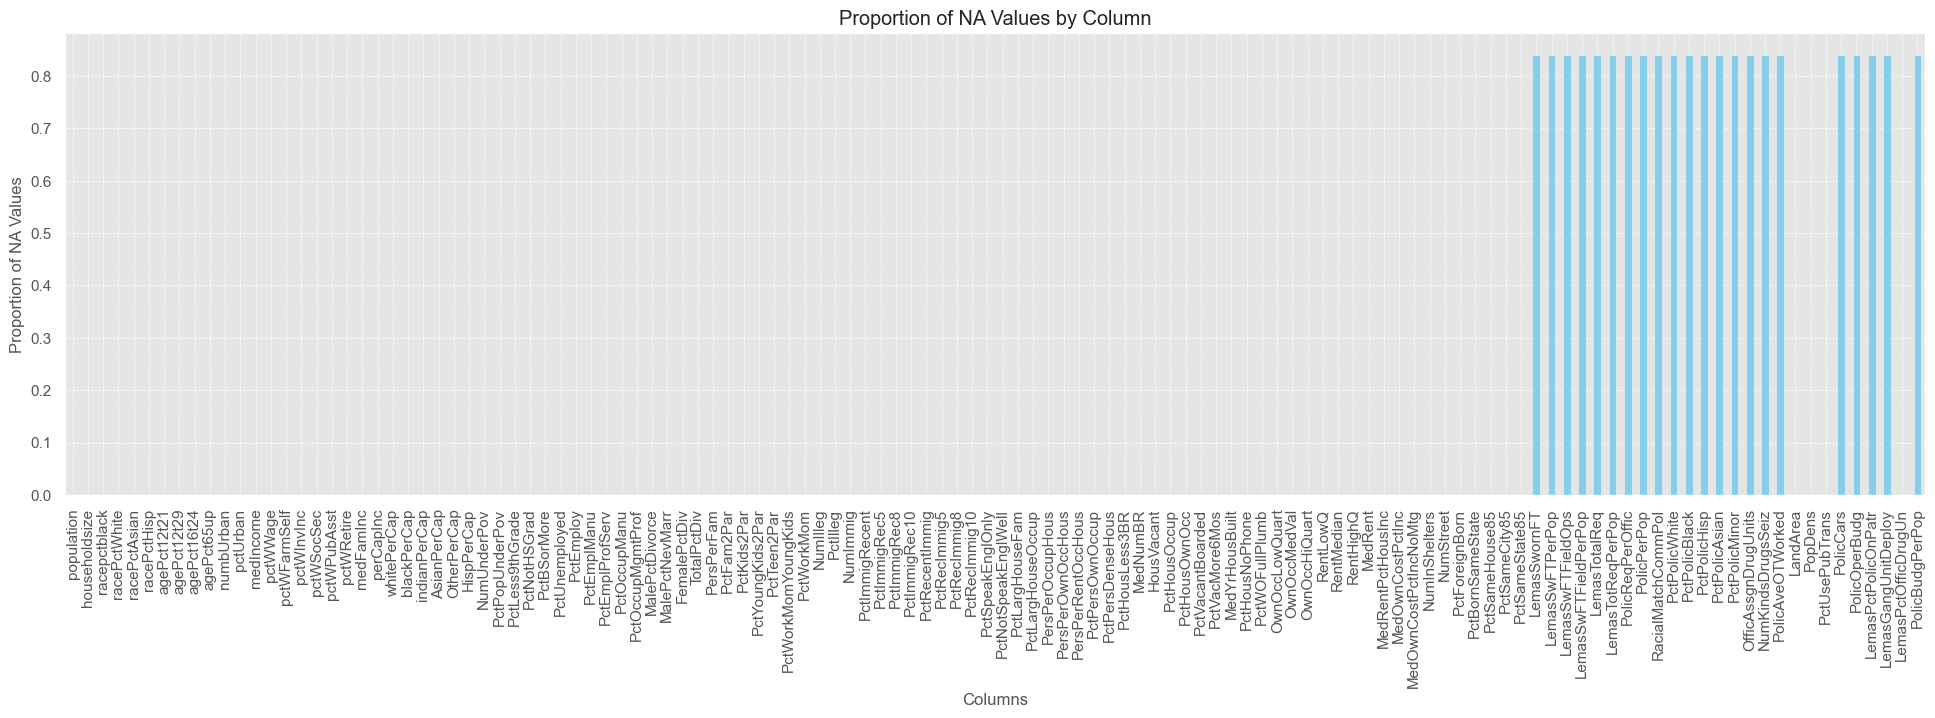

In [10]:
plt.figure(figsize=(24, 6))  # Adjust the size of the figure as needed
na_proportion.plot(kind='bar', color='skyblue')
plt.title('Proportion of NA Values by Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of NA Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Since missing values are concentrated in few columns, we drop the columns with missing values.

**Additional info on the dataset:**

Many variables are included so that algorithms that select or learn weights for 
attributes could be tested. However, clearly unrelated attributes were not included; 
attributes were picked if there was any plausible connection to crime (N=122), plus 
the attribute to be predicted (Per Capita Violent Crimes). The variables included in 
the dataset involve the community, such as the percent of the population considered 
urban, and the median family income, and involving law enforcement, such as per capita 
number of police officers, and percent of officers assigned to drug units.

The per capita violent crimes variable was calculated using population and the sum of 
crime variables considered violent crimes in the United States: murder, rape, robbery, 
and assault. There was apparently some controversy in some states concerning the 
counting of rapes. These resulted in missing values for rape, which resulted in 
incorrect values for per capita violent crime. These cities are not included in the 
dataset. Many of these omitted communities were from the midwestern USA.

Data is described below based on original values. All numeric data was normalized into 
the decimal range 0.00-1.00 using an Unsupervised, equal-interval binning method. 
Attributes retain their distribution and skew (hence for example the population 
attribute has a mean value of 0.06 because most communities are small). E.g. An 
attribute described as 'mean people per household' is actually the normalized (0-1) 
version of that value.

The normalization preserves rough ratios of values WITHIN an attribute (e.g. double 
the value for double the population within the available precision - except for 
extreme values (all values more than 3 SD above the mean are normalized to 1.00; all 
values more than 3 SD below the mean are nromalized to 0.00)).

However, the normalization does not preserve relationships between values BETWEEN 
attributes (e.g. it would not be meaningful to compare the value for whitePerCap with 
the value for blackPerCap for a community)

A limitation was that the LEMAS survey was of the police departments with at least 100 
officers, plus a random sample of smaller departments. For our purposes, communities 
not found in both census and crime datasets were omitted. Many communities are missing 
LEMAS data.




In [11]:
na_indices = list(zip(*np.where(X.isna())))
missing_value_columns = X.columns[X.isna().any()].tolist()

In [12]:
X_drop = X.drop(columns =missing_value_columns)
assert X_drop.isna().any().any() == False

In [13]:
X_drop.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.000000,0.060000,0.470000,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.000000,0.130000,0.630000,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.000000,0.280000,0.777500,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
## TODO, maybe add additional EDA eg PCA ...

## Transforming the Dataset

In [15]:
def hermite_transform(df, max_degree):
    """
    Apply Hermite polynomial transformation starting at degree 2
    """
    feature_transforms = {}
    for col in df.columns: 
        for d in range(2, max_degree + 1):
            feature_transforms[f'{col}_{d}'] = np.array(hermval(df[col], [0]*d + [1]))
            
    feature_transforms_df = pd.DataFrame(feature_transforms)
    feature_transforms_df = pd.concat([df, feature_transforms_df], axis=1)
    return feature_transforms_df


In [16]:
def add_interaction_terms(df):
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_features = poly.fit_transform(df)
    interaction_feature_names = poly.get_feature_names_out(df.columns)
    interaction_feature_names = interaction_feature_names[len(df.columns):]
    interaction_df = pd.DataFrame(interaction_features[:, len(df.columns):], columns=interaction_feature_names)
    new_df = pd.concat([df, interaction_df], axis=1)
    return new_df

In [17]:
max_degree = 10

In [18]:
X_hermite = hermite_transform(X_drop, max_degree)

In [19]:
X_hermite_interaction = pd.concat([X_hermite, add_interaction_terms(X_drop)], axis=1)

In [20]:
X_hermite_interaction.shape

(1994, 5940)

In [21]:
X_hermite_interaction.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctSameState85 LandArea,PctSameState85 PopDens,PctSameState85 PctUsePubTrans,PctSameState85 LemasPctOfficDrugUn,LandArea PopDens,LandArea PctUsePubTrans,LandArea LemasPctOfficDrugUn,PopDens PctUsePubTrans,PopDens LemasPctOfficDrugUn,PctUsePubTrans LemasPctOfficDrugUn
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.0768,0.1664,0.1280,0.2048,0.0312,0.0240,0.0384,0.0520,0.0832,0.064
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.0104,0.0624,0.2340,0.0000,0.0024,0.0090,0.0000,0.0540,0.0000,0.000
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.0056,0.1176,0.0112,0.0000,0.0021,0.0002,0.0000,0.0042,0.0000,0.000
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.0130,0.2535,0.1820,0.0000,0.0078,0.0056,0.0000,0.1092,0.0000,0.000
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.0212,0.0477,0.0106,0.0000,0.0036,0.0008,0.0000,0.0018,0.0000,0.000


## Generate Simulated Data Using Best LASSO

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hermite_interaction)

In [426]:
lasso_cv = LassoCV(cv=5, random_state=0, n_alphas=100, selection='random', tol= 1e-3, fit_intercept=False)
lasso_cv.fit(X_scaled, y_arr)

LassoCV(cv=5, fit_intercept=False, random_state=0, selection='random',
        tol=0.001)

In [427]:
mean_squared_error(lasso_cv.predict(X_scaled), y_arr)

0.07396806994757063

In [428]:
sum(lasso_cv.coef_ != 0)

33

In [429]:
y_pred = lasso_cv.predict(X_scaled)
empirical_error = y_arr - y_pred
empirical_error

array([0.2493611 , 0.58842816, 0.31268729, ..., 0.0618083 , 0.27556875,
       0.296078  ])

In [430]:
empirical_error.mean()

0.23797893681043128

In [431]:
empirical_error.var()

0.017334095582147383

In [433]:
true_coefs = lasso_cv.coef_

Text(0, 0.5, 'Residuals')

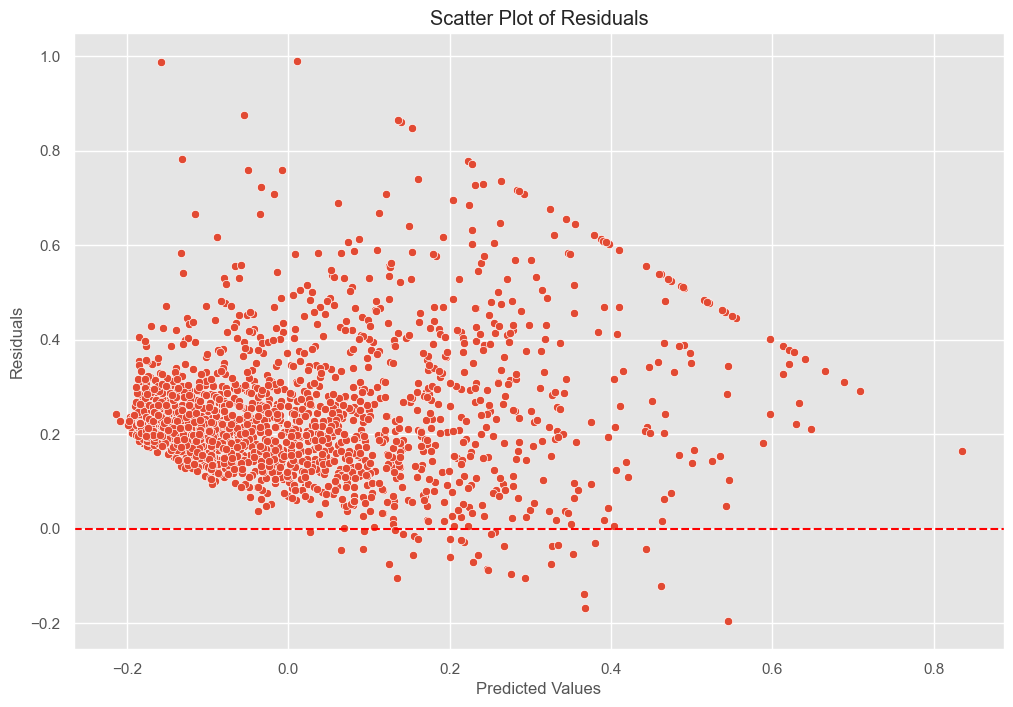

In [432]:
sns.scatterplot(x=y_pred, y=empirical_error)
plt.axhline(0, color='red', linestyle='--') 
plt.title('Scatter Plot of Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Assuming the true relationship is $y=X_{scaled} \beta_{LASSO} + \epsilon_{LASSO}$ where $\epsilon_{LASSO}$ is sampled from the empirical distribution of the error computed above.

In [434]:
sampled_errors = np.random.choice(empirical_error, size=X_scaled.shape[0], replace=True)

In [435]:
y_simulated = X_scaled @ lasso_cv.coef_ + sampled_errors
y_simulated

array([0.15497809, 0.26679424, 0.18260594, ..., 0.42305512, 0.0922533 ,
       0.43526097])

Text(0, 0.5, 'Residuals')

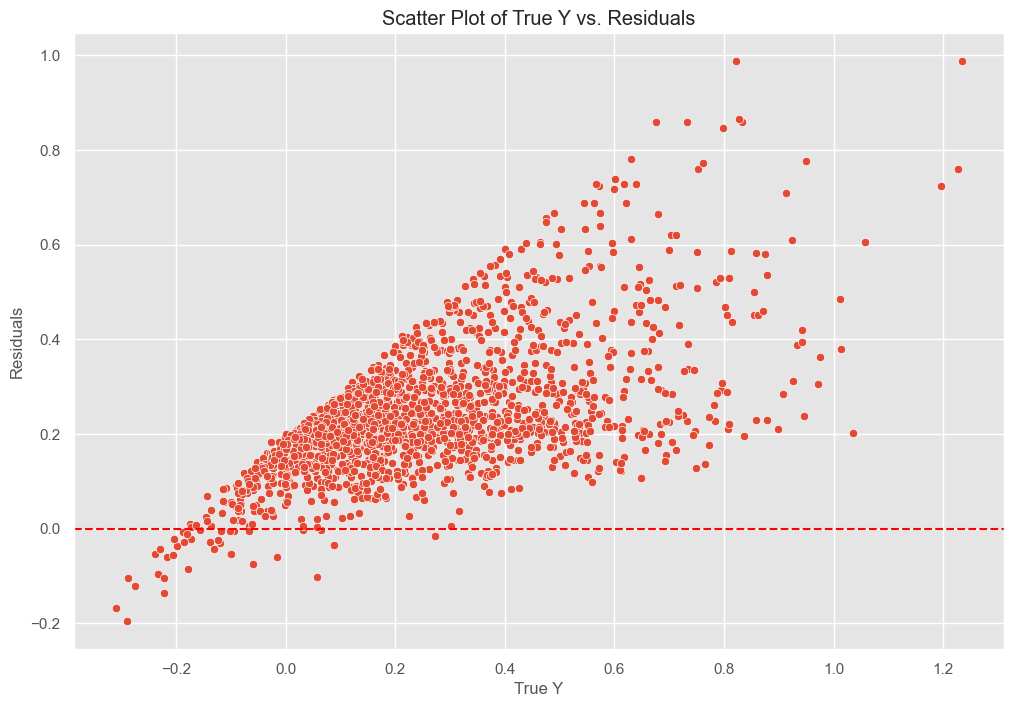

In [437]:
sns.scatterplot(x=y_simulated, y=sampled_errors)
plt.axhline(0, color='red', linestyle='--') 
plt.title('Scatter Plot of True Y vs. Residuals')
plt.xlabel('True Y')
plt.ylabel('Residuals')

We now rank the coefficients by their tendency to decrease towards zero in the best Lasso model.

In [34]:
alphas, coefs, _ = lasso_path(X_scaled, y_arr, eps=1e-5)

In [35]:
non_zero_features_ranked = np.argsort(-abs(true_coefs))[:sum(true_coefs!= 0)]
zero_features = np.argsort(-abs(true_coefs))[sum(true_coefs != 0):]

In [37]:
lasso_cv.alpha_

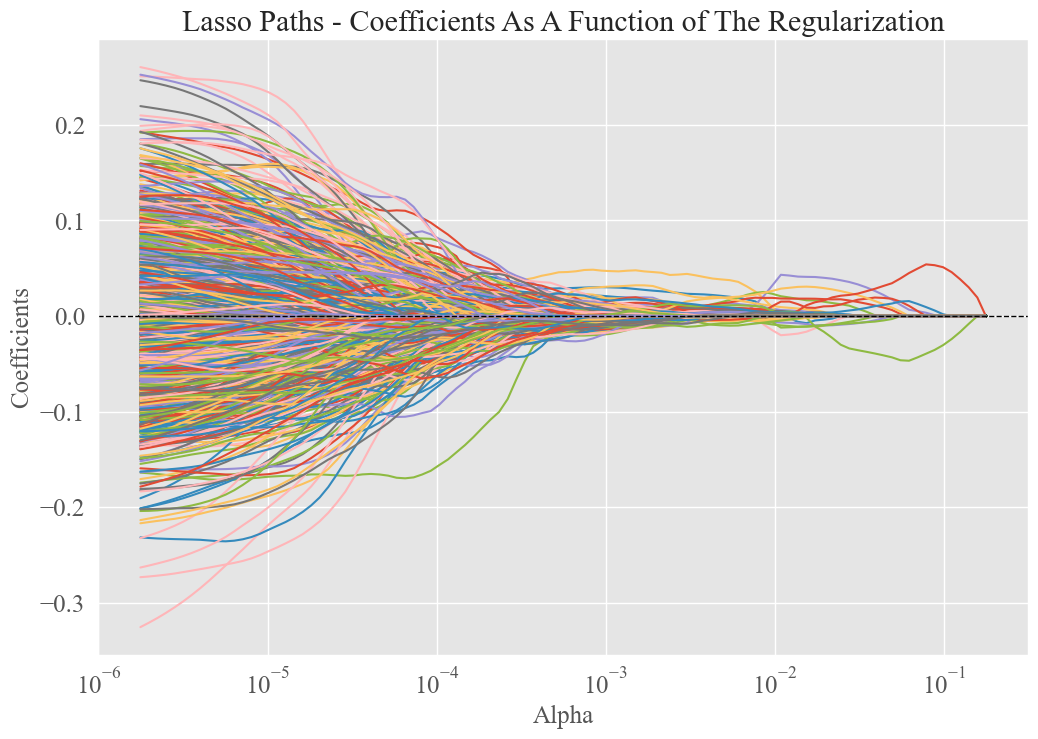

In [48]:
for coef_l in coefs:
    plt.plot(alphas, coef_l)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Coefficients As A Function of The Regularization')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xscale('log')
plt.show()

In [ ]:
zero_threshold = 1e-5  # Define a threshold to consider as zero
zero_alphas = np.zeros(coefs.shape[0])

for i, coef in enumerate(coefs):
    # Check where coefficient falls below the zero threshold
    alpha_index = np.where(np.abs(coef) < zero_threshold)[0]
    if alpha_index.size > 0:
        # the smallest alpha that push the coef to 0
        zero_alphas[i] = alphas[np.max(alpha_index)]
    else:
        zero_alphas[i] = np.inf  

# Rank features by the alpha at which their coefficients reach zero
# Higher alpha means the feature coefficient reaches zero later
feature_ranking = np.argsort(-zero_alphas)  
feature_ranking

In [ ]:
filtered_list = list(filter(lambda x: x not in non_zero_features_ranked, feature_ranking))
feature_ranking = list(non_zero_features_ranked) + filtered_list

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns= X_hermite_interaction.columns)
X_scaled_ranked = X_scaled_df.iloc[:, feature_ranking]
X_scaled_ranked.head()

In [510]:
# import json

# simulated_y_error = pd.DataFrame({'y_simulated':y_simulated, 'sampled_errors': sampled_errors})
# coefs = {'coefs': lasso_cv.coef_.tolist()}
# X_scaled_ranked.to_csv('X_scaled_ranked.csv')
# simulated_y_error.to_csv('simulated_y_error.csv')

In [72]:
# X_scaled_ranked = pd.read_csv('X_scaled_ranked.csv', index_col=0)
# y_simulated = np.array(pd.read_csv('simulated_y_error.csv', index_col=0).iloc[:, 0])
# sampled_errors = np.array(pd.read_csv('simulated_y_error.csv', index_col=0).iloc[:, 1])

In [55]:
X_scaled_ranked

,PctKids2Par_8,MalePctDivorce PctPersDenseHous,racepctblack_3,racepctblack PctHousLess3BR,pctUrban PctIlleg,MalePctDivorce PctIlleg,NumStreet_3,racePctWhite PctHousOccup,pctWPubAsst MedRent,HousVacant_3,...,pctWPubAsst_7,pctWRetire PctSameState85,medFamInc PctPopUnderPov,medFamInc PctBSorMore,medFamInc PctEmplProfServ,medFamInc PctOccupMgmtProf,medFamInc MalePctNevMarr,medFamInc FemalePctDiv,medFamInc PctFam2Par,population.1
0,-0.135795,-0.296965,0.762573,-0.588591,-0.153321,-0.260500,0.280092,0.351746,-0.668167,-1.561529,...,0.281354,-0.270571,-0.132951,0.103793,-0.078720,0.039656,-0.029250,1.644723,-0.216934,1.043612
1,0.674721,1.015570,0.092583,-0.005320,0.281215,0.673013,0.280092,0.134881,0.132059,0.481225,...,-0.657561,-0.730442,-0.247921,-0.429093,-0.948449,-0.477869,0.243305,1.277919,-0.665460,-0.453937
2,0.892339,0.017930,-1.891357,0.996558,-0.761671,0.994069,0.280092,-0.275726,0.369426,0.592294,...,-1.008619,0.969302,-0.094628,-0.608849,-0.666758,-0.555708,-0.449822,0.442989,-0.700923,-0.453937
3,0.184114,-0.489874,-1.361117,-0.589914,0.672297,-0.150903,0.280092,-1.886263,1.136960,0.592294,...,-0.104859,1.366925,-0.723129,-0.050967,0.441324,0.019144,0.721042,1.098364,0.367449,-0.138663
4,-0.739926,-0.834084,0.762573,-0.630915,-0.527022,-0.789147,0.280092,1.174953,-0.798932,0.592294,...,0.620549,0.371597,-1.320972,-0.084472,0.032611,0.085938,-0.353866,-0.926758,0.802489,-0.375118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.601607,-0.506895,0.224846,-0.332005,-0.283682,-0.597674,0.280092,0.405563,-1.043405,0.481225,...,1.071261,-0.879074,-0.350116,0.525529,0.809688,0.482497,0.094267,0.995761,0.001835,-0.375118
1990,-0.363335,1.785313,-1.779811,1.169158,1.063379,0.262989,0.280092,-1.302642,1.446816,0.370245,...,-0.952985,-2.018589,-0.063969,-0.610976,-0.538242,-0.724008,0.215743,-0.382963,-0.497138,-0.059845
1991,1.037790,-0.166468,-0.725715,0.435109,1.584822,0.866420,-0.038426,-0.407678,1.131275,-1.561529,...,-0.996223,0.733015,0.745929,-0.500889,-0.227411,-0.437897,0.271888,0.137746,-0.554078,0.807157
1992,-0.465391,-0.482309,0.492408,-0.402103,-0.022960,-0.523534,0.120801,0.717705,0.790148,0.148729,...,-0.375863,-0.532266,-0.104848,0.158039,0.728244,0.159570,2.552367,-0.298316,0.214111,0.176610


## Simulate Double Descent Analysis with A Small Sample

### Analyzing Double Descent

In [56]:
def svd_regression(X, y):
    U, s, Vt = scipy.linalg.svd(X, full_matrices=False)
    X_pinv = scipy.linalg.pinv(X, atol= 1e-20, check_finite=True)
    coef = X_pinv @ y
    return U, s, Vt, coef, X_pinv

In [57]:
def perform_svd_regression(X_train_inv, y_train):
    beta_hat = X_train_inv @ y_train
    return beta_hat

def perform_principal_angles_analysis(X_train, X_test):
    Q_test, _ = qr(X_test.T, mode='economic')  
    Q_train, _ = qr(X_train.T, mode='economic') 
    U, sigma, Vt = svd(Q_test.T @ Q_train)
    cosine_angles = sigma
    
    principal_angles_degrees = np.degrees(np.arccos(np.clip(cosine_angles, -1, 1)))
    mean_angle_degrees = np.mean(principal_angles_degrees)
    min_angle_degrees = np.min(principal_angles_degrees)
    max_angle_degrees = np.max(principal_angles_degrees)
    sd_angle_degrees = np.std(principal_angles_degrees)
    return mean_angle_degrees, sd_angle_degrees, min_angle_degrees, max_angle_degrees

def calculated_the_best_error_projection(U, S, train_indices, scores):
    train_best_score = scores[train_indices]
    projections = U.T @ train_best_score
    max_projection = np.max(projections)
    max_projection_index = np.argmax(projections)
    max_projection_singular_value = S[max_projection_index]
    max_singular = np.max(S)
    return max_projection, max_projection_singular_value, max_singular


In [85]:
def run_DD_analysis(X, y, P_sizes, scores, folds=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)
    results = []

    for P in P_sizes:
        X_p = X.iloc[:, :P]
    
        fold_idx = 0
    
        for train_index, test_index in kf.split(X_p):
            X_train, X_test = np.array(X_p.iloc[train_index, :]), np.array(X_p.iloc[test_index, :])
            y_train, y_test = y[train_index], y[test_index]
        
            ##################################
            # scaler = StandardScaler()
            # scaler.fit(X_train)
            # X_train_scaled = scaler.transform(X_train)
            # X_test_scaled = scaler.transform(X_test)
            ##################################
            
            # U, S, Vt = scipy.linalg.svd(X_train_scaled, full_matrices=False)
            # X_train_inv = np.linalg.pinv(X_train_scaled)
            
            ##################################
            # U, S, Vt, beta_hat, X_train_pinv = svd_regression(X_train_scaled, y_train)
            ##################################
            if P == 0:
                train_mse = mean_squared_error(y_train, [0] * len(y_train))
                test_mse = mean_squared_error(y_test, [0] * len(y_test))
                det = np.nan
                min_singular_value = np.nan
                max_singular = np.nan
                mean_angle_degrees = np.nan
                sd_angle_degrees = np.nan
                min_angle_degrees = np.nan
                max_angle_degrees = np.nan
                max_projection = np.nan
                max_projection_singular_value = np.nan
                mean_variance = np.nan
                max_variance = np.nan
                min_variance = np.nan
            else:
            
                U, S, Vt, beta_hat, X_train_pinv = svd_regression(X_train, y_train)
                min_singular_value = np.min(S[S > 0.0])
                det = np.linalg.det(X_train.T @ X_train)

                # beta_hat = perform_svd_regression(X_train_inv, np.array(y_train))

                mean_angle_degrees, sd_angle_degrees, min_angle_degrees, max_angle_degrees = perform_principal_angles_analysis(X_train, X_test)

                max_projection, max_projection_singular_value, max_singular = calculated_the_best_error_projection(U, S, train_index, scores)

                y_train_pred = X_train @ beta_hat
                train_mse = mean_squared_error(y_train, y_train_pred)
                train_mse = train_mse if train_mse > 1e-15 else 0
                y_test_pred = X_test @ beta_hat
                test_mse = mean_squared_error(y_test, y_test_pred)

                variances = X_test @ X_train_pinv @ scores[train_index]
                mean_variance = np.mean(variances)
                max_variance = np.max(variances)
                min_variance = np.min(variances)
        
            results.append({
                "P": P,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Fold Index": fold_idx,
                "Training Maxtrix Determinant": det,
                "Minimum Singular Value": min_singular_value,
                "Maximum Singular Value": max_singular,
                "Mean Principal Angle (degree)": mean_angle_degrees,
                "Standard Deviation Principal Angle (degree)": sd_angle_degrees,
                "Min Principal Angle (degree)": min_angle_degrees,
                "Max Principal Angle (degree)": max_angle_degrees,
                "Max Projection (UE)": max_projection,
                "Max Projection Singular Value": max_projection_singular_value,
                "Mean Variance": mean_variance,
                "Max Variance": max_variance,
                "Min Variance": min_variance
            })
        
            fold_idx += 1  
        
        if P % 100 == 0:
            print(f"Processed {P} features")

    result_df = pd.DataFrame(results)
    return result_df

In [59]:
random_indices = np.random.choice(X_scaled_ranked.shape[0], size=100, replace=False)

In [62]:
X_scaled_ranked

,PctKids2Par_8,MalePctDivorce PctPersDenseHous,racepctblack_3,racepctblack PctHousLess3BR,pctUrban PctIlleg,MalePctDivorce PctIlleg,NumStreet_3,racePctWhite PctHousOccup,pctWPubAsst MedRent,HousVacant_3,...,pctWPubAsst_7,pctWRetire PctSameState85,medFamInc PctPopUnderPov,medFamInc PctBSorMore,medFamInc PctEmplProfServ,medFamInc PctOccupMgmtProf,medFamInc MalePctNevMarr,medFamInc FemalePctDiv,medFamInc PctFam2Par,population.1
0,-0.135795,-0.296965,0.762573,-0.588591,-0.153321,-0.260500,0.280092,0.351746,-0.668167,-1.561529,...,0.281354,-0.270571,-0.132951,0.103793,-0.078720,0.039656,-0.029250,1.644723,-0.216934,1.043612
1,0.674721,1.015570,0.092583,-0.005320,0.281215,0.673013,0.280092,0.134881,0.132059,0.481225,...,-0.657561,-0.730442,-0.247921,-0.429093,-0.948449,-0.477869,0.243305,1.277919,-0.665460,-0.453937
2,0.892339,0.017930,-1.891357,0.996558,-0.761671,0.994069,0.280092,-0.275726,0.369426,0.592294,...,-1.008619,0.969302,-0.094628,-0.608849,-0.666758,-0.555708,-0.449822,0.442989,-0.700923,-0.453937
3,0.184114,-0.489874,-1.361117,-0.589914,0.672297,-0.150903,0.280092,-1.886263,1.136960,0.592294,...,-0.104859,1.366925,-0.723129,-0.050967,0.441324,0.019144,0.721042,1.098364,0.367449,-0.138663
4,-0.739926,-0.834084,0.762573,-0.630915,-0.527022,-0.789147,0.280092,1.174953,-0.798932,0.592294,...,0.620549,0.371597,-1.320972,-0.084472,0.032611,0.085938,-0.353866,-0.926758,0.802489,-0.375118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.601607,-0.506895,0.224846,-0.332005,-0.283682,-0.597674,0.280092,0.405563,-1.043405,0.481225,...,1.071261,-0.879074,-0.350116,0.525529,0.809688,0.482497,0.094267,0.995761,0.001835,-0.375118
1990,-0.363335,1.785313,-1.779811,1.169158,1.063379,0.262989,0.280092,-1.302642,1.446816,0.370245,...,-0.952985,-2.018589,-0.063969,-0.610976,-0.538242,-0.724008,0.215743,-0.382963,-0.497138,-0.059845
1991,1.037790,-0.166468,-0.725715,0.435109,1.584822,0.866420,-0.038426,-0.407678,1.131275,-1.561529,...,-0.996223,0.733015,0.745929,-0.500889,-0.227411,-0.437897,0.271888,0.137746,-0.554078,0.807157
1992,-0.465391,-0.482309,0.492408,-0.402103,-0.022960,-0.523534,0.120801,0.717705,0.790148,0.148729,...,-0.375863,-0.532266,-0.104848,0.158039,0.728244,0.159570,2.552367,-0.298316,0.214111,0.176610


In [70]:
np.array(y_simulated[random_indices])

array([ 0.05940392,  0.04857128,  0.42399809,  0.19053716,  0.26415365,
        0.01367883,  0.31985955,  0.15872114,  0.14885573,  0.13306991,
        0.1689248 ,  0.45430801,  0.07445255, -0.03402375,  0.35009835,
        0.23069091,  0.07881296,  0.11213204,  0.69174594,  0.37548306,
        0.82149185,  0.69155106,  0.57317783,  0.53100208, -0.03158168,
        0.37601263,  0.25150951,  0.08590192,  0.17195254,  0.3929074 ,
        0.14311854,  0.12039589,  0.14149036, -0.02709511,  0.26650775,
        0.59869075,  0.24840558,  0.21471397,  0.30220266,  0.22514197,
       -0.00782555,  0.02465603,  0.06474463,  0.36184801,  0.21145355,
        0.04228394,  0.34929631,  0.32879008,  0.06169222,  0.00686264,
        0.30571852,  0.49010021,  0.17565647, -0.00224288,  0.52055034,
        0.44605599,  0.24072207,  0.23192341,  0.21696351, -0.07957449,
        0.06256753,  0.4999437 ,  0.07551165,  0.25199373,  0.42985431,
        0.31106744,  0.63096081,  0.19788468,  0.42684385,  0.11

In [86]:
def simulated_sample_DD(n, max_P, folds=10):
    n_samples = n

    # random_indices = np.random.choice(X_scaled_ranked.shape[0], size=n_samples, replace=False)

    X_sampled = X_scaled_ranked.iloc[random_indices, :].reset_index().drop(columns=['index'])
    y_sampled = y_simulated[random_indices]
    scores = sampled_errors[random_indices]
    
    P_sizes = np.arange(0, max_P+1, 1)
    result_df = run_DD_analysis(X_sampled, y_sampled, P_sizes, scores, folds)
    return result_df 

In [568]:
result_df20 = simulated_sample_DD(20, 100)

In [87]:
result_df100 = simulated_sample_DD(100, 800)

Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features


In [88]:
result_df100.head()

,P,Train MSE,Test MSE,Fold Index,Training Maxtrix Determinant,Minimum Singular Value,Maximum Singular Value,Mean Principal Angle (degree),Standard Deviation Principal Angle (degree),Min Principal Angle (degree),Max Principal Angle (degree),Max Projection (UE),Max Projection Singular Value,Mean Variance,Max Variance,Min Variance
0,0,0.097121,0.093892,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.097924,0.086671,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.102369,0.046659,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.093245,0.128778,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.102173,0.048425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
result_df100.groupby('P')['Test MSE'].mean().min()

0.07355501174399068

In [102]:
result_df100[result_df100['P']>=90].groupby('P')['Test MSE'].mean().argmin()

470

(-1.0, 800.0)

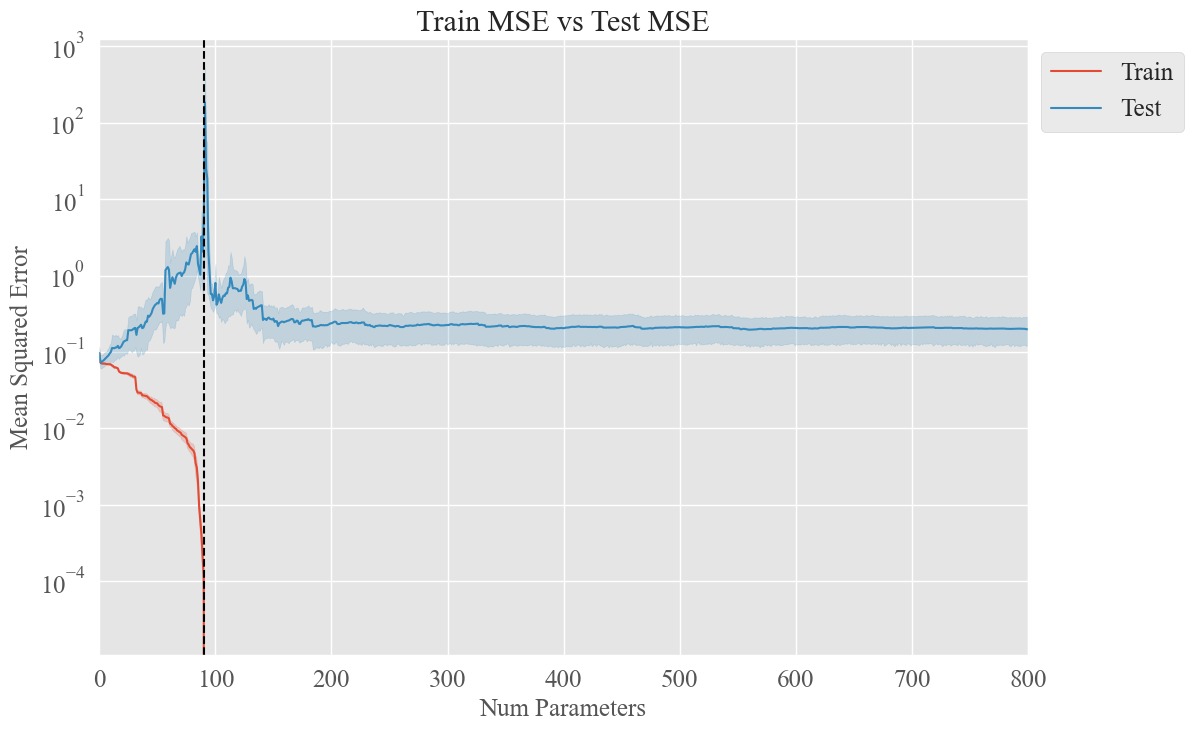

In [94]:
fig, ax = plt.subplots()
sns.lineplot(
    data=result_df100,
    x="P",
    y="Train MSE",
    label="Train",
    ax=ax,
)
sns.lineplot(
    data=result_df100,
    x="P",
    y="Test MSE",
    label="Test",
    ax=ax,
)
ax.set_xlabel("Num Parameters")
ax.set_ylabel("Mean Squared Error")
ax.axvline(x=100 * 0.9, color="black", linestyle="--", label="Interpolation Threshold")
ax.set_title(f"Train MSE vs Test MSE")
# ax.set_xscale("log")
ax.set_yscale("log")
sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1.0, 1.0))
ax.set_xlim(-1, 800)


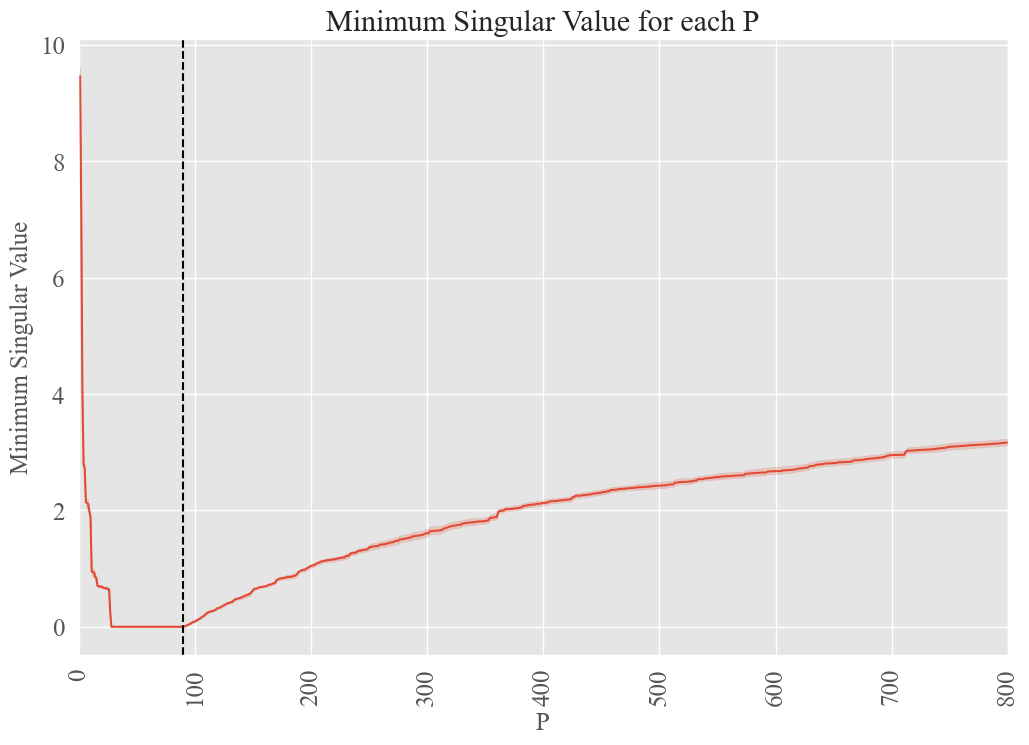

In [97]:
fig, ax = plt.subplots()
sns.lineplot(x='P', y='Minimum Singular Value', data=result_df100[result_df100['P'] != 0])
ax.axvline(x=100 * 0.9, color="black", linestyle="--", label="Interpolation Threshold")

plt.title('Minimum Singular Value for each P')
plt.xlabel('P')
plt.ylabel('Minimum Singular Value')
plt.xlim(-1, 800)
plt.xticks(rotation=90);

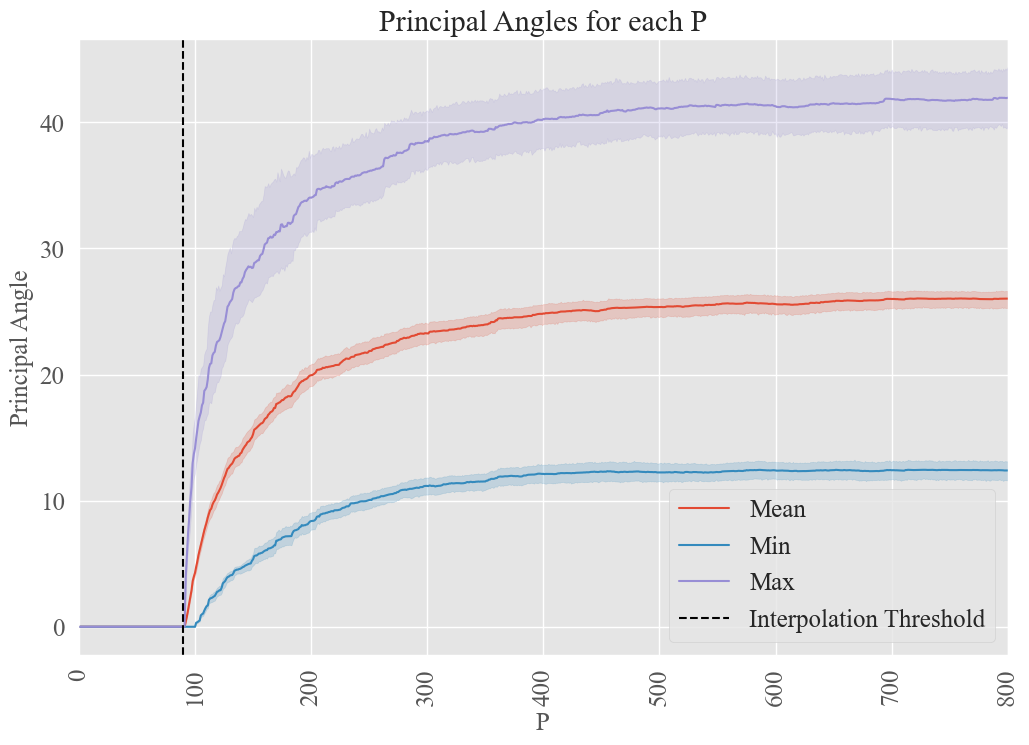

In [98]:
fig, ax = plt.subplots()
sns.lineplot(x='P', y='Mean Principal Angle (degree)', data=result_df100[result_df100['P'] != 0], label='Mean')
sns.lineplot(x='P', y='Min Principal Angle (degree)', data=result_df100[result_df100['P'] != 0], label='Min')
sns.lineplot(x='P', y='Max Principal Angle (degree)', data=result_df100[result_df100['P'] != 0], label='Max')
ax.axvline(x=100 * 0.9, color="black", linestyle="--", label="Interpolation Threshold")

plt.legend()
plt.title('Principal Angles for each P')
plt.xlim(-1, 800)
plt.xlabel('P')
plt.ylabel('Principal Angle')
plt.xticks(rotation=90);

Text(0.5, 0, 'P')

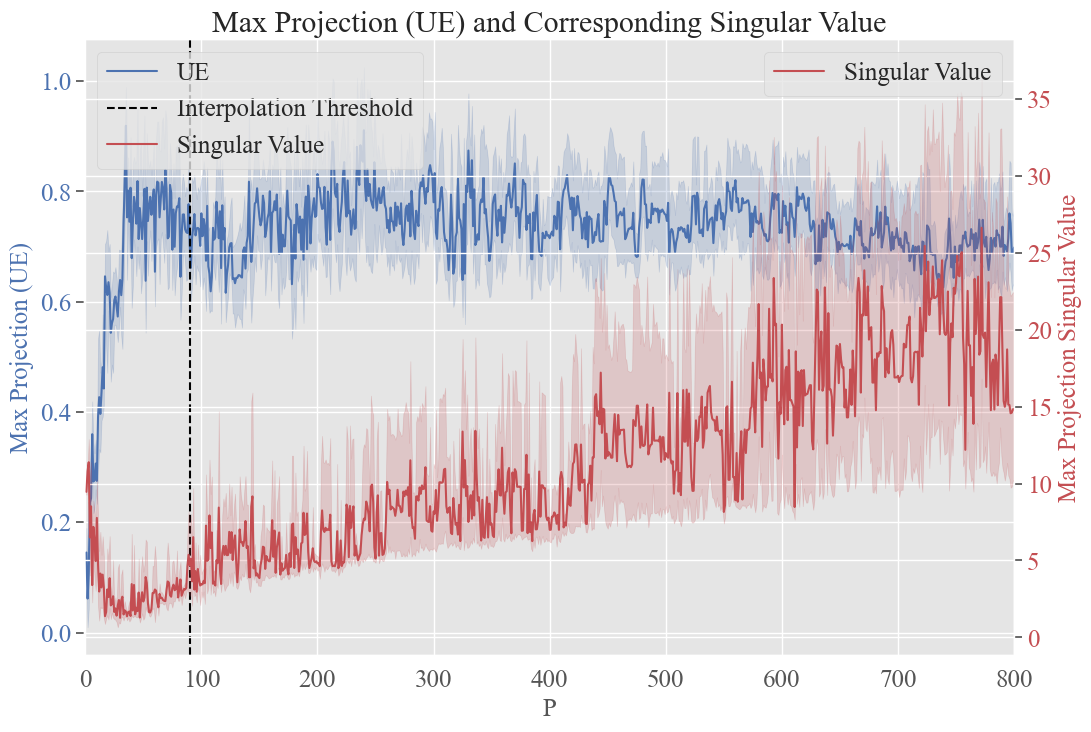

In [99]:
fig, ax1 = plt.subplots()

sns.lineplot(x='P', y='Max Projection (UE)', data=result_df100[result_df100['P'] != 0], label='UE', ax=ax1, color='b')
ax1.set_ylabel('Max Projection (UE)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
sns.lineplot(x='P', y='Max Projection Singular Value', data=result_df100[result_df100['P'] != 0], label='Singular Value', ax=ax2, color='r')
ax2.set_ylabel('Max Projection Singular Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')

threshold = 100 * 0.9
ax1.axvline(x=threshold, color="black", linestyle="--", label="Interpolation Threshold")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

ax1.legend(handles, labels, loc="upper left")
plt.xlim(-1, 800)
ax1.set_title('Max Projection (UE) and Corresponding Singular Value')
ax1.set_xlabel('P')

In [580]:
result_df500 = simulated_sample_DD(500, 1500)

Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features
Processed 900 features
Processed 1000 features
Processed 1100 features
Processed 1200 features
Processed 1300 features
Processed 1400 features


## Removing the Most Informative Features

In [103]:
def simulated_sample_DD_removed(n, max_P, folds=10):
    n_samples = n

    # random_indices = np.random.choice(X_scaled_ranked.shape[0], size=n_samples, replace=False)

    X_sampled = X_scaled_ranked.iloc[random_indices, len(non_zero_features_ranked):].reset_index().drop(columns=['index'])
    y_sampled = y_simulated[random_indices]
    scores = sampled_errors[random_indices]
    
    P_sizes = np.arange(0, max_P+1, 1)
    result_df = run_DD_analysis(X_sampled, y_sampled, P_sizes, scores, folds)
    return result_df 

In [927]:
result_df100_removed = simulated_sample_DD_removed(100, 800)

Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features


In [928]:
result_df100_removed

,P,Train MSE,Test MSE,Fold Index,Training Maxtrix Determinant,Minimum Singular Value,Maximum Singular Value,Mean Principal Angle (degree),Standard Deviation Principal Angle (degree),Min Principal Angle (degree),Max Principal Angle (degree),Max Projection (UE),Max Projection Singular Value,Mean Variance,Max Variance,Min Variance
0,1,0.088293,0.108552,0,93.148734,9.651359,9.651359,0.000000,0.000000,0.000000,0.000000,0.497347,9.651359,-0.013400,0.081938,-0.054775
1,1,0.091632,0.076418,1,87.485315,9.353359,9.353359,0.000000,0.000000,0.000000,0.000000,0.464851,9.353359,0.007984,0.142676,-0.052827
2,1,0.086404,0.123233,2,99.099188,9.954858,9.954858,0.000000,0.000000,0.000000,0.000000,0.443129,9.954858,-0.002912,0.036165,-0.047315
3,1,0.089147,0.098507,3,85.389995,9.240671,9.240671,0.000000,0.000000,0.000000,0.000000,0.320491,9.240671,0.015161,0.102915,-0.036866
4,1,0.094631,0.049148,4,89.653057,9.468530,9.468530,0.000000,0.000000,0.000000,0.000000,0.352560,9.468530,0.015936,0.084753,-0.039578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7985,799,0.000000,0.313005,5,0.000000,3.605566,104.372060,25.395235,8.788414,12.661397,37.590093,0.561608,16.886868,-0.097940,0.343189,-1.185232
7986,799,0.000000,0.291770,6,-0.000000,3.449177,108.385605,28.678979,11.472501,15.185643,55.648186,0.653278,26.597631,-0.122971,0.225287,-1.319592
7987,799,0.000000,0.130384,7,-0.000000,3.396248,106.562976,27.187061,8.445496,14.048601,40.824810,0.665107,8.417870,0.119133,0.696134,-0.519995
7988,799,0.000000,0.082370,8,0.000000,3.353139,108.916968,25.463600,8.957803,12.299581,39.780658,0.745079,22.399669,0.138192,0.422234,-0.556054


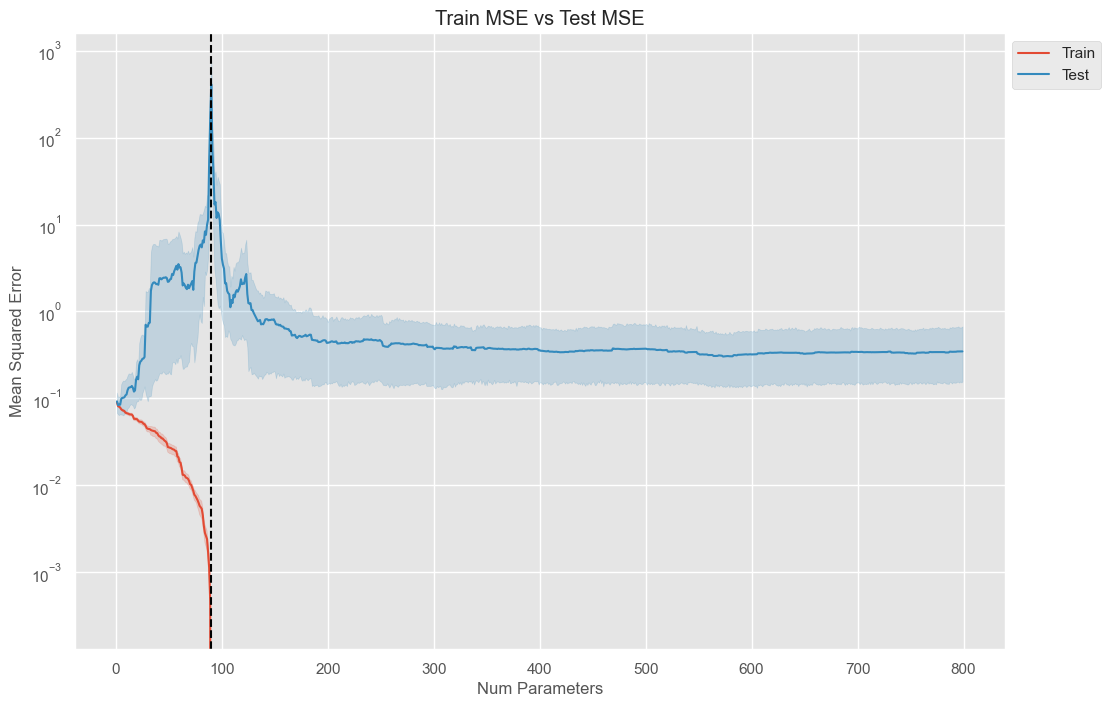

In [929]:
fig, ax = plt.subplots()
sns.lineplot(
    data=result_df100_removed,
    x="P",
    y="Train MSE",
    label="Train",
    ax=ax,
)
sns.lineplot(
    data=result_df100_removed,
    x="P",
    y="Test MSE",
    label="Test",
    ax=ax,
)
ax.set_xlabel("Num Parameters")
ax.set_ylabel("Mean Squared Error")
ax.axvline(x=100 * 0.9, color="black", linestyle="--", label="Interpolation Threshold")
ax.set_title(f"Train MSE vs Test MSE")
# ax.set_xscale("log")
ax.set_yscale("log")
sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1.0, 1.0))
  


## Analyzing Simulated Examples with Different Signal to Noise Ratio

Define SNR = $\frac{\text{Var}(X\beta)}{\sigma^2}$

In [107]:
signal = (X_scaled @ true_coefs).var()
error_var = sampled_errors.var()

In [106]:
# error_mean = empirical_error.mean()
# error_var = empirical_error.var()

In [108]:
# beta_22 = np.linalg.norm(lasso_cv.coef_) ** 2

In [109]:
print(f'Previous SNR: {signal/ error_var}')

Previous SNR: 1.8131454090783485


In [112]:
def simulate_y_errors(error_mean, error_var):
    num_samples = X_scaled_ranked.shape[0]
    sample_errors = np.random.normal(error_mean, error_var, num_samples)
    y_simulated1 = X_scaled @ true_coefs + sample_errors
    return y_simulated1, sample_errors

In [ ]:
def simulated_sample_DD_error_adjusted(y_simulated, sample_errors, n, max_P, folds=10):
    n_samples = n

    # random_indices = np.random.choice(X_scaled_ranked.shape[0], size=n_samples, replace=False)

    X_sampled = X_scaled_ranked.iloc[random_indices, :].reset_index().drop(columns=['index'])
    y_sampled = y_simulated[random_indices]
    scores = sampled_errors[random_indices]
    
    P_sizes = np.arange(0, max_P+1, 1)
    result_df = run_DD_analysis(X_sampled, y_sampled, P_sizes, scores, folds)
    return result_df 

### Increase SNR

In [115]:
error_var1 = error_var / 8

In [671]:
y_simulated1, sample_errors1 = simulate_y_errors(0, error_var1)

In [954]:
beta_22/error_var

0.24762502393156638

In [672]:
SRN = beta_22 / error_var1

In [673]:
print(f'Current SNR: {SRN}')

Current SNR: 1.981000191452531


In [116]:
def plot_MSE_DD(df, null_risk, threshold=100):
    fig, ax = plt.subplots()
    sns.lineplot(
        data=df,
        x="P",
        y="Train MSE",
        label="Train",
        ax=ax,
    )
    sns.lineplot(
        data=df,
        x="P",
        y="Test MSE",
        label="Test",
        ax=ax,
    )
    plt.axhline(y=null_risk, color='red', linestyle='--', label='Null Risk')
    ax.set_xlabel("Num Parameters")
    ax.set_ylabel("Mean Squared Error")
    ax.axvline(x=threshold * 0.9, color="black", linestyle="--", label="Interpolation Threshold")
    ax.set_title(f"Train MSE vs Test MSE")
    ax.set_yscale("log")
    plt.legend()
    sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1.0, 1.0))
  


In [119]:
# ratios = [0.5, 1, 8, 16, 24]
ratios = [0.5, 1,  8]
result_dfs = []
SRNs = []
null_error = []

for r in ratios:
    error_var_temp = error_var / r
    y_simulated_temp, sample_errors_temp = simulate_y_errors(0, error_var_temp)
    y_mean_temp = np.mean(y_simulated_temp)
    y_pred_null = np.full_like(y_simulated_temp, fill_value=y_mean_temp)
    null_risk = mean_squared_error(y_simulated_temp, y_pred_null)
    null_error.append(null_risk)
    SRN_temp = signal/ error_var_temp
    SRNs.append(SRN_temp)
    result_df_temp =  simulated_sample_DD_error_adjusted(y_simulated_temp, sample_errors_temp, 100, 800)
    result_dfs.append(result_df_temp)

Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features
Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features
Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features


In [120]:
SRNs

[0.9065727045391743, 1.8131454090783485, 14.505163272626788]

In [121]:
null_error

[0.03162275117624285, 0.030897910208601085, 0.03056965850433366]

In [122]:
result_dfs[0]

,P,Train MSE,Test MSE,Fold Index,Training Maxtrix Determinant,Minimum Singular Value,Maximum Singular Value,Mean Principal Angle (degree),Standard Deviation Principal Angle (degree),Min Principal Angle (degree),Max Principal Angle (degree),Max Projection (UE),Max Projection Singular Value,Mean Variance,Max Variance,Min Variance
0,0,0.025330,0.015179,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.024505,0.022600,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.024929,0.018784,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.023522,0.031454,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.025461,0.014000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,800,0.000000,0.003151,5,0.0,3.097978,103.247555,27.299633,9.859386,10.438249,41.449548,0.631592,16.373025,-0.234329,0.322815,-0.886297
8006,800,0.000000,0.002189,6,0.0,3.218087,107.776070,23.385018,6.949401,12.364093,36.132222,0.674192,11.419368,0.048057,0.291433,-0.235054
8007,800,0.000000,0.005749,7,0.0,3.153407,106.522250,26.955316,9.287133,13.142290,43.062304,0.668527,11.180390,-0.120457,0.379841,-0.626232
8008,800,0.000000,0.002393,8,-0.0,3.417882,106.942269,25.475049,10.155257,12.263611,45.121656,0.926270,11.383679,-0.029805,0.193443,-0.376718


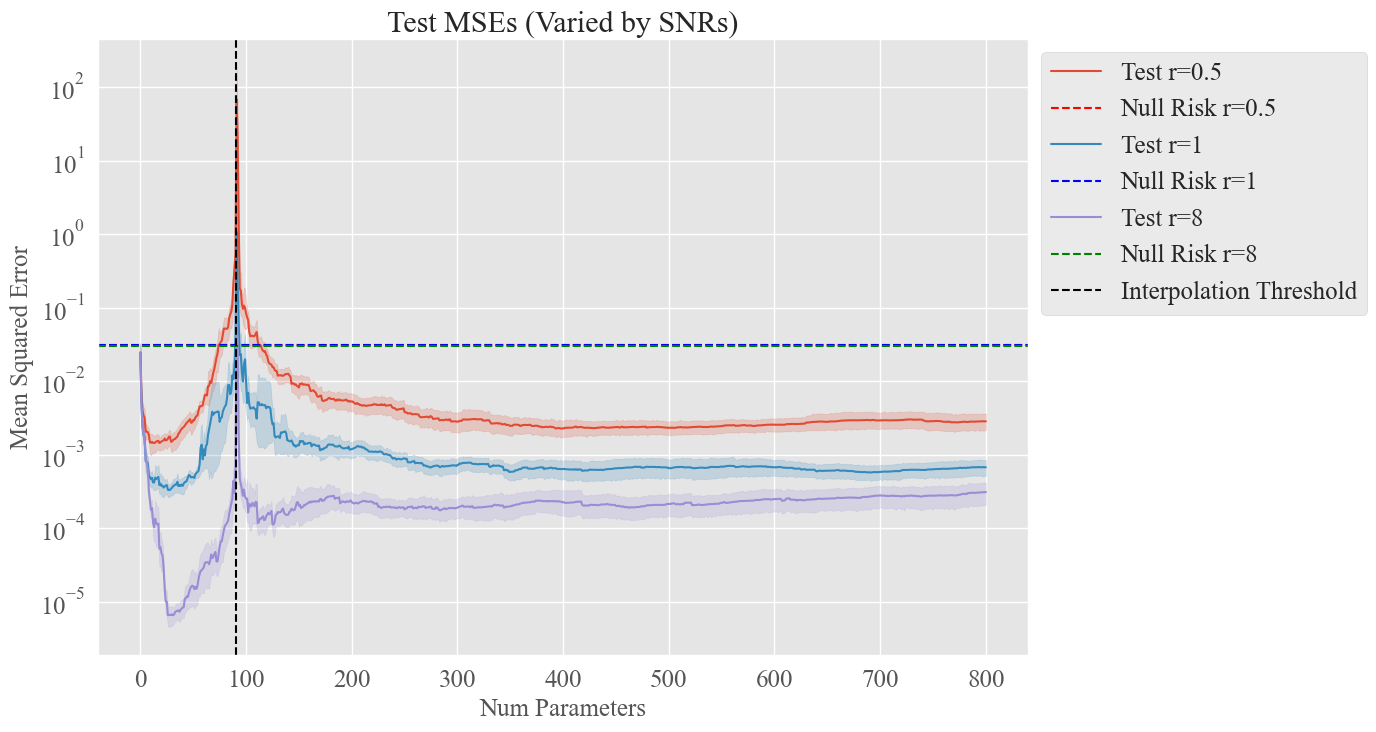

In [123]:
fig, ax = plt.subplots()

sns.lineplot(
    data=result_dfs[0],
    x="P",
    y="Test MSE",
    label="Test r=0.5",
    ax=ax,
)
plt.axhline(y=null_error[0], color='red', linestyle='--', label='Null Risk r=0.5')


sns.lineplot(
    data=result_dfs[1],
    x="P",
    y="Test MSE",
    label="Test r=1",
    ax=ax,
)
plt.axhline(y=null_error[1], color='blue', linestyle='--', label='Null Risk r=1')


sns.lineplot(
    data=result_dfs[2],
    x="P",
    y="Test MSE",
    label="Test r=8",
    ax=ax,
)
plt.axhline(y=null_error[2], color='green', linestyle='--', label='Null Risk r=8')

ax.set_xlabel("Num Parameters")
ax.set_ylabel("Mean Squared Error")
ax.axvline(x=100 * 0.9, color="black", linestyle="--", label="Interpolation Threshold")
ax.set_title(f"Test MSEs (Varied by SNRs)")
ax.set_yscale("log")
plt.legend()
sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1.0, 1.0))

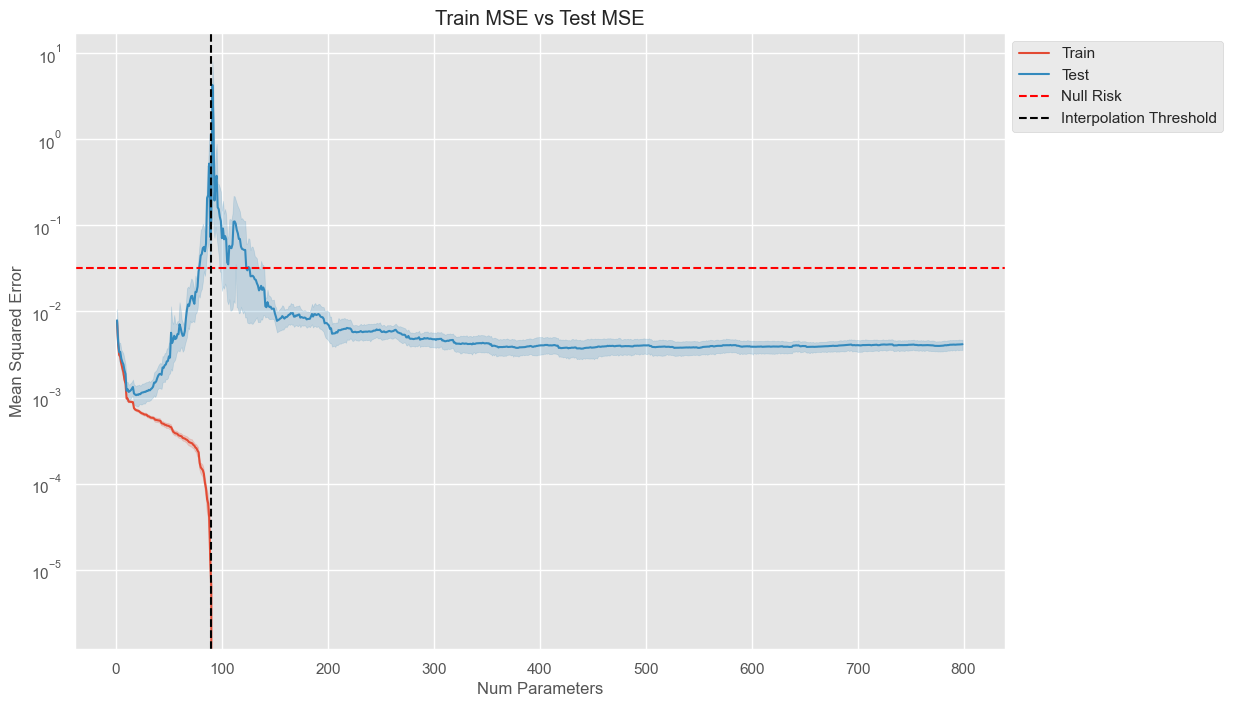

In [960]:
plot_MSE_DD(result_dfs[0], null_risk=null_error[0])


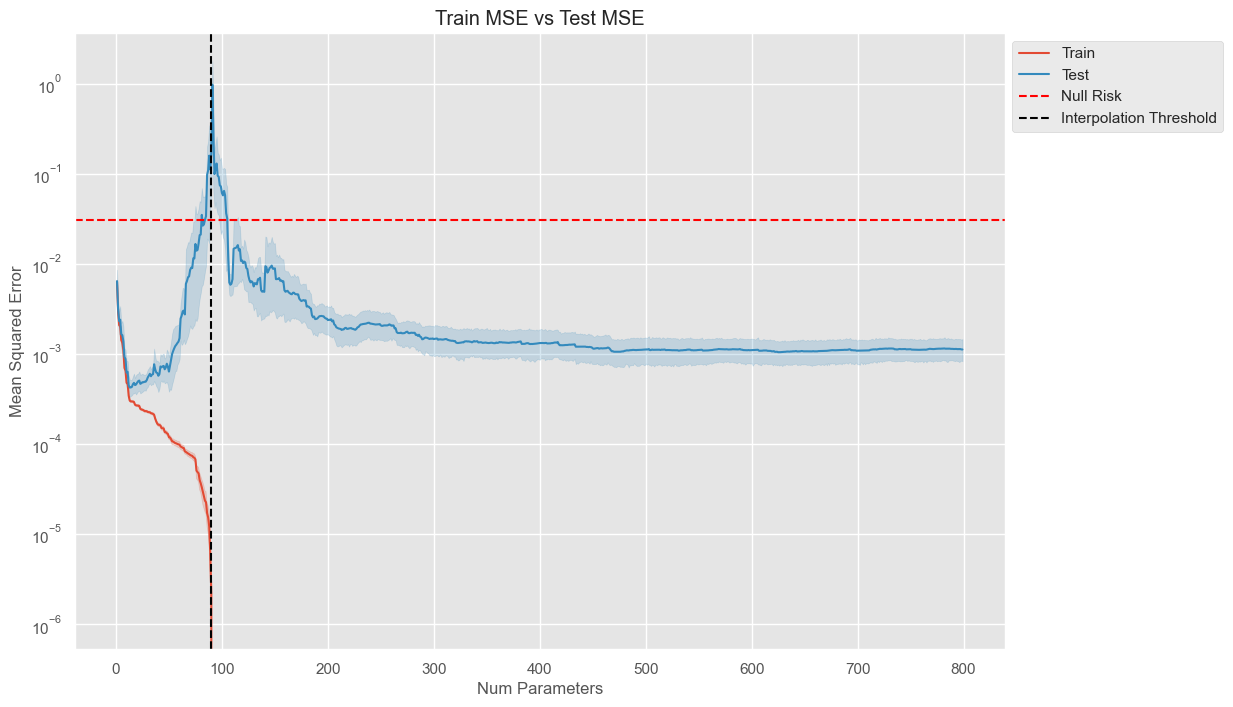

In [935]:
plot_MSE_DD(result_dfs[1], null_risk=null_error[1])

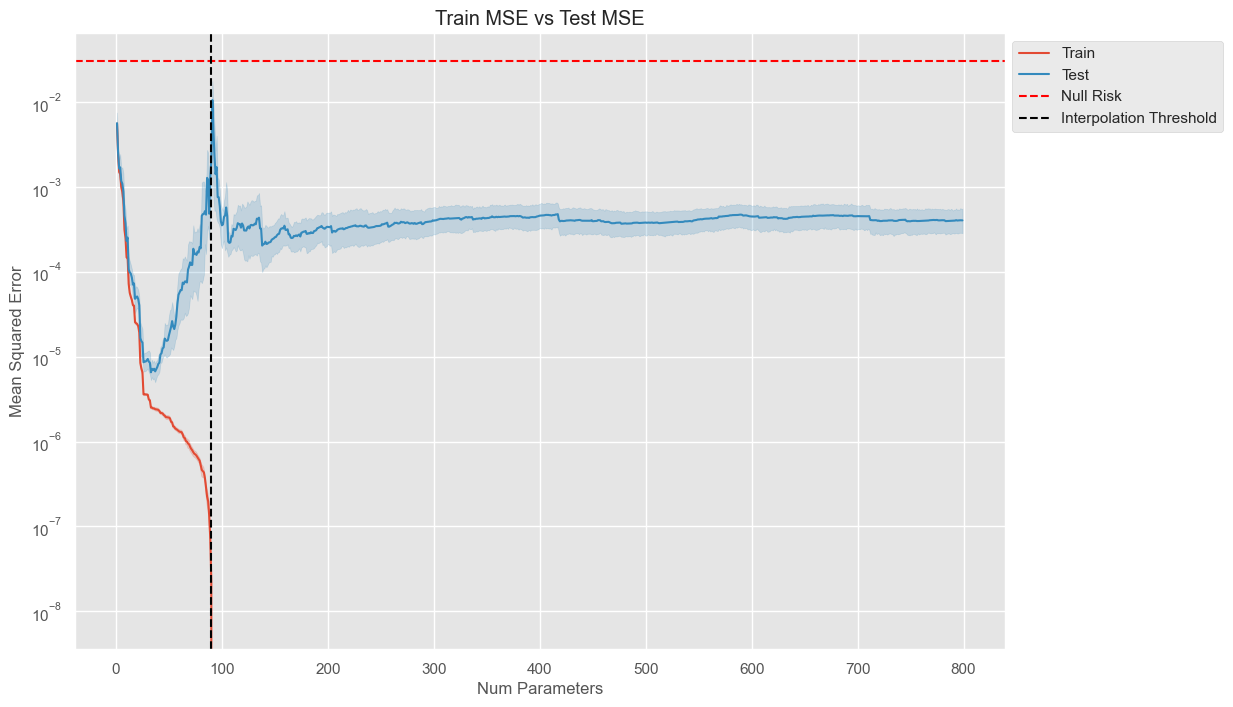

In [936]:
plot_MSE_DD(result_dfs[2], null_risk=null_error[2])

## Removing Most Informative Features and Vary SNR

In [124]:
def simulated_sample_DD_error_adjusted_removed(y_simulated, sample_errors, n, max_P, folds=10):
    n_samples = n

    # random_indices = np.random.choice(X_scaled_ranked.shape[0], size=n_samples, replace=False)

    X_sampled = X_scaled_ranked.iloc[random_indices, len(non_zero_features_ranked):].reset_index().drop(columns=['index'])
    y_sampled = y_simulated[random_indices]
    scores = sampled_errors[random_indices]
    
    P_sizes = np.arange(0, max_P+1, 1)
    result_df = run_DD_analysis(X_sampled, y_sampled, P_sizes, scores, folds)
    return result_df 

In [126]:
result_dfs_removed = []
SRNs_removed = []
null_error_removed = []

for r in ratios:
    error_var_temp = error_var / r
    y_simulated_temp, sample_errors_temp = simulate_y_errors(0, error_var_temp)
    y_mean_temp = np.mean(y_simulated_temp)
    y_pred_null = np.full_like(y_simulated_temp, fill_value=y_mean_temp)
    null_risk = mean_squared_error(y_simulated_temp, y_pred_null)
    null_error_removed.append(null_risk)
    SRN_temp = signal/ error_var_temp
    SRNs_removed.append(SRN_temp)
    result_df_temp =  simulated_sample_DD_error_adjusted_removed(y_simulated_temp, sample_errors_temp, 100, 800)
    result_dfs_removed.append(result_df_temp)

Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features
Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features
Processed 0 features
Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features
Processed 700 features
Processed 800 features


In [127]:
SRNs_removed

[0.9065727045391743, 1.8131454090783485, 14.505163272626788]

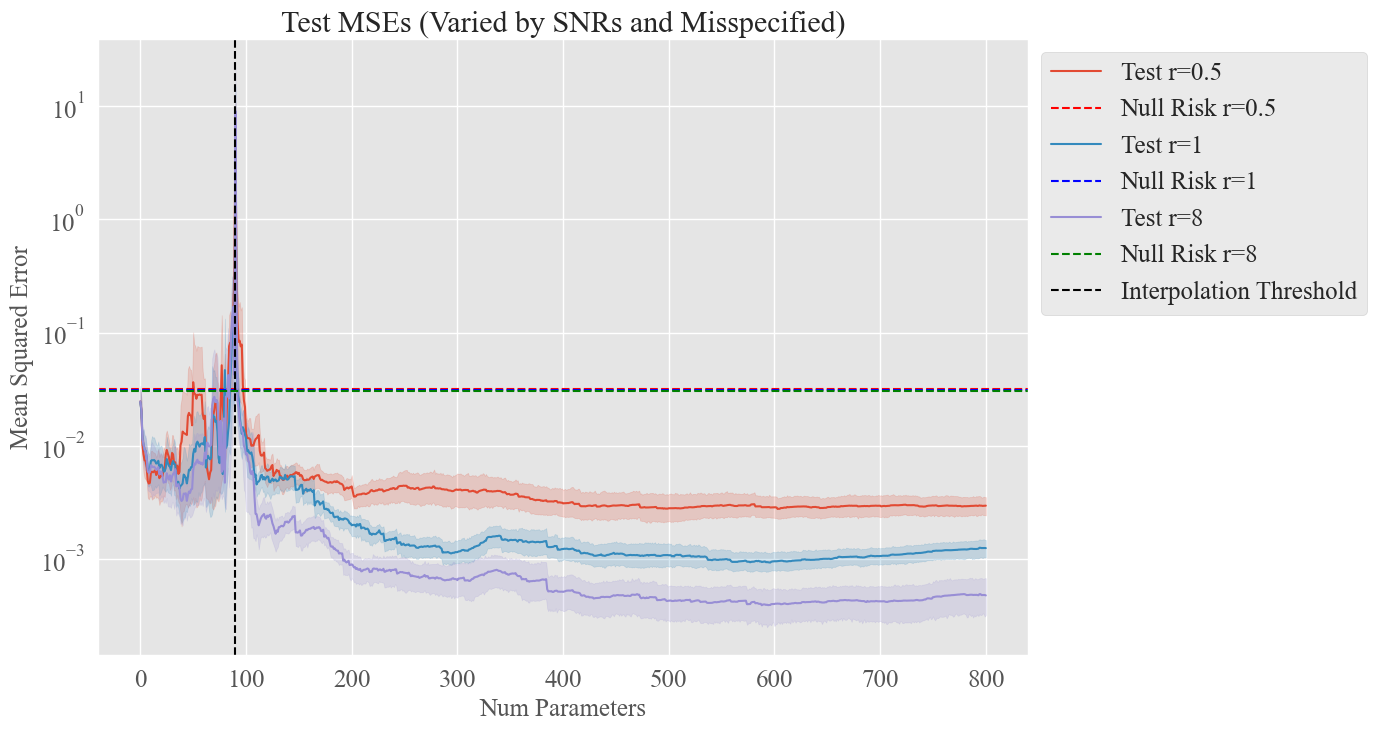

In [128]:
fig, ax = plt.subplots()

sns.lineplot(
    data=result_dfs_removed[0],
    x="P",
    y="Test MSE",
    label="Test r=0.5",
    ax=ax,
)
plt.axhline(y=null_error_removed[0], color='red', linestyle='--', label='Null Risk r=0.5')


sns.lineplot(
    data=result_dfs_removed[1],
    x="P",
    y="Test MSE",
    label="Test r=1",
    ax=ax,
)
plt.axhline(y=null_error_removed[1], color='blue', linestyle='--', label='Null Risk r=1')


sns.lineplot(
    data=result_dfs_removed[2],
    x="P",
    y="Test MSE",
    label="Test r=8",
    ax=ax,
)
plt.axhline(y=null_error_removed[2], color='green', linestyle='--', label='Null Risk r=8')

ax.set_xlabel("Num Parameters")
ax.set_ylabel("Mean Squared Error")
ax.axvline(x=100 * 0.9, color="black", linestyle="--", label="Interpolation Threshold")
ax.set_title(f"Test MSEs (Varied by SNRs and Misspecified)")
ax.set_yscale("log")
plt.legend()
sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1.0, 1.0))

In [129]:
print(f"Local Min in the classical regime: {result_dfs_removed[0][result_dfs_removed[0]['P']<90].groupby('P')['Test MSE'].mean().min()}")
print(f"Local Min in the modern ML regime: {result_dfs_removed[0][result_dfs_removed[0]['P']>=90].groupby('P')['Test MSE'].mean().min()}")

Local Min in the classical regime: 0.004626437051594109
Local Min in the modern ML regime: 0.002760446648518339


In [130]:
print(f"Local Min in the classical regime: {result_dfs_removed[1][result_dfs_removed[1]['P']<90].groupby('P')['Test MSE'].mean().min()}")
print(f"Local Min in the modern ML regime: {result_dfs_removed[1][result_dfs_removed[1]['P']>=90].groupby('P')['Test MSE'].mean().min()}")

Local Min in the classical regime: 0.0041627641233358366
Local Min in the modern ML regime: 0.0009261866176130222


In [131]:
print(f"Local Min in the classical regime: {result_dfs_removed[2][result_dfs_removed[2]['P']<90].groupby('P')['Test MSE'].mean().min()}")
print(f"Local Min in the modern ML regime: {result_dfs_removed[2][result_dfs_removed[2]['P']>=90].groupby('P')['Test MSE'].mean().min()}")

Local Min in the classical regime: 0.003245452440737287
Local Min in the modern ML regime: 0.000388769894292826


In [150]:
post_columns = np.array(X_scaled_ranked.iloc[:, len(non_zero_features_ranked):].columns[:801])
prev_columns = np.array(X_scaled_ranked.columns[:801])

In [145]:
# columns_pre_post = pd.DataFrame({'Pre': prev_columns, 'Post': post_columns})
# columns_pre_post.to_csv('columns_pre_post.csv')

In [148]:
correlation_matrix = X_scaled_ranked.corr()

In [157]:
num_removed_col = len(non_zero_features_ranked)

In [158]:
removed_columns = prev_columns[:num_removed_col]

In [168]:
target_column = removed_columns[0]
target_column

'PctKids2Par_8'

In [166]:
sorted_correlations = correlation_matrix[target_column][num_removed_col:].sort_values(ascending=False)
sorted_correlations

PctFam2Par_8            0.980603
pctWSocSec PctIlleg     0.912917
PctKids2Par_4           0.911502
PctYoungKids2Par_8      0.908188
TotalPctDiv PctIlleg    0.906700
                          ...   
PctFam2Par.1           -0.920138
PctFam2Par_10          -0.929311
PctKids2Par_10         -0.934210
PctFam2Par_6           -0.945447
PctKids2Par_6          -0.968262
Name: PctKids2Par_8, Length: 5907, dtype: float64

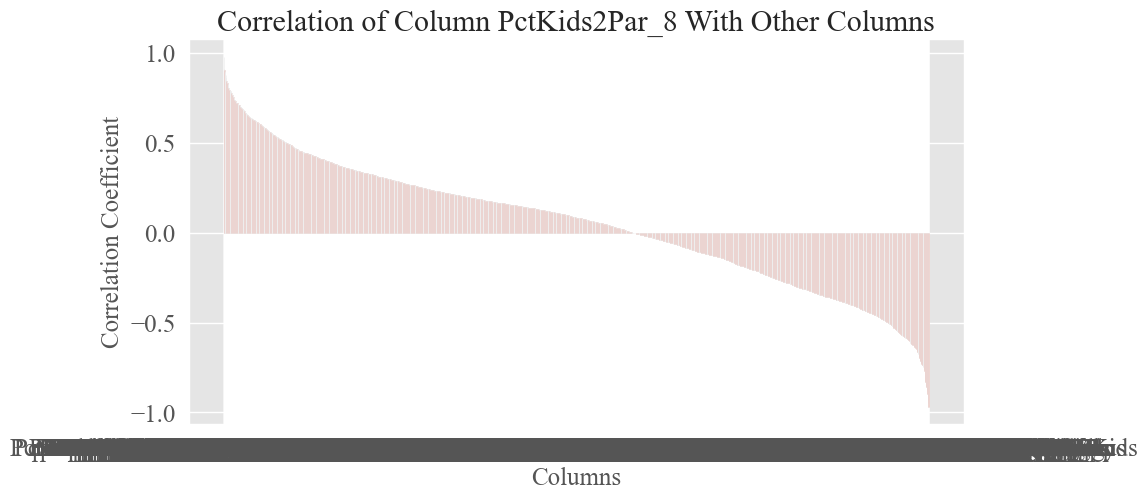

In [167]:
plt.figure(figsize=(10, 5))
plt.bar(sorted_correlations.index, sorted_correlations.values)
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficient')
plt.title(f'Correlation of Column {target_column} With Other Columns')
plt.grid(True)

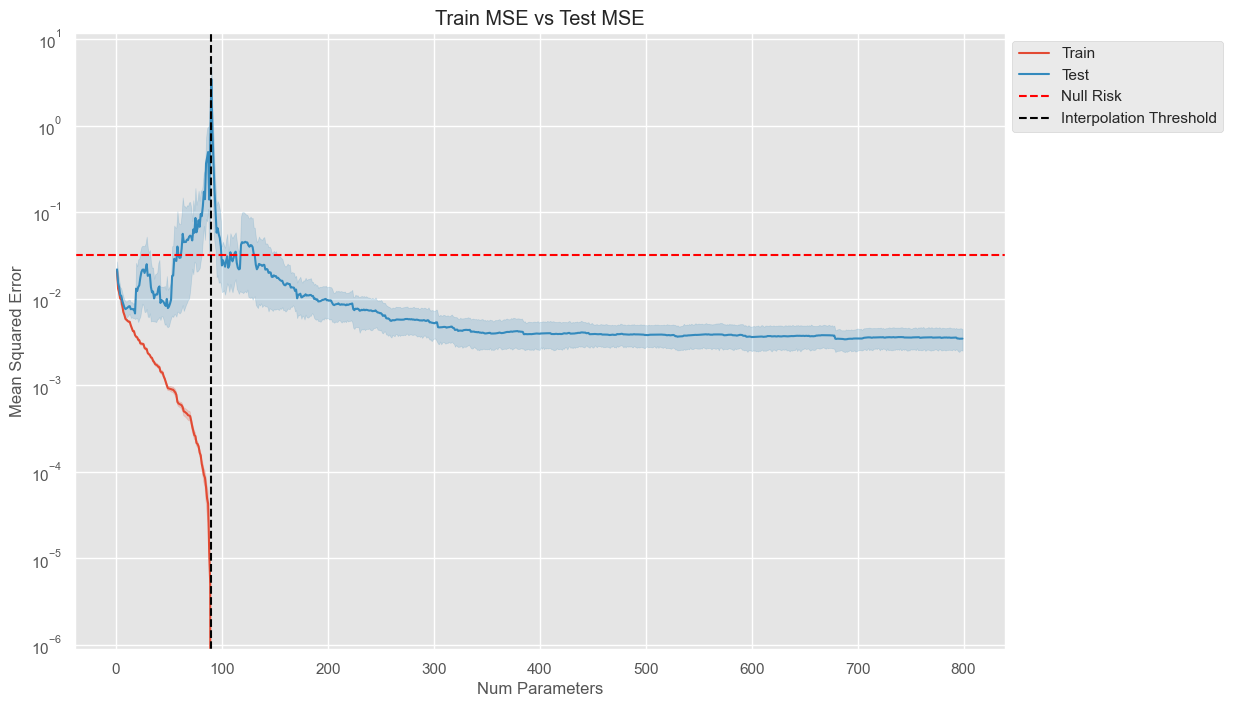

In [942]:
plot_MSE_DD(result_dfs_removed[0], null_risk=null_error_removed[0])

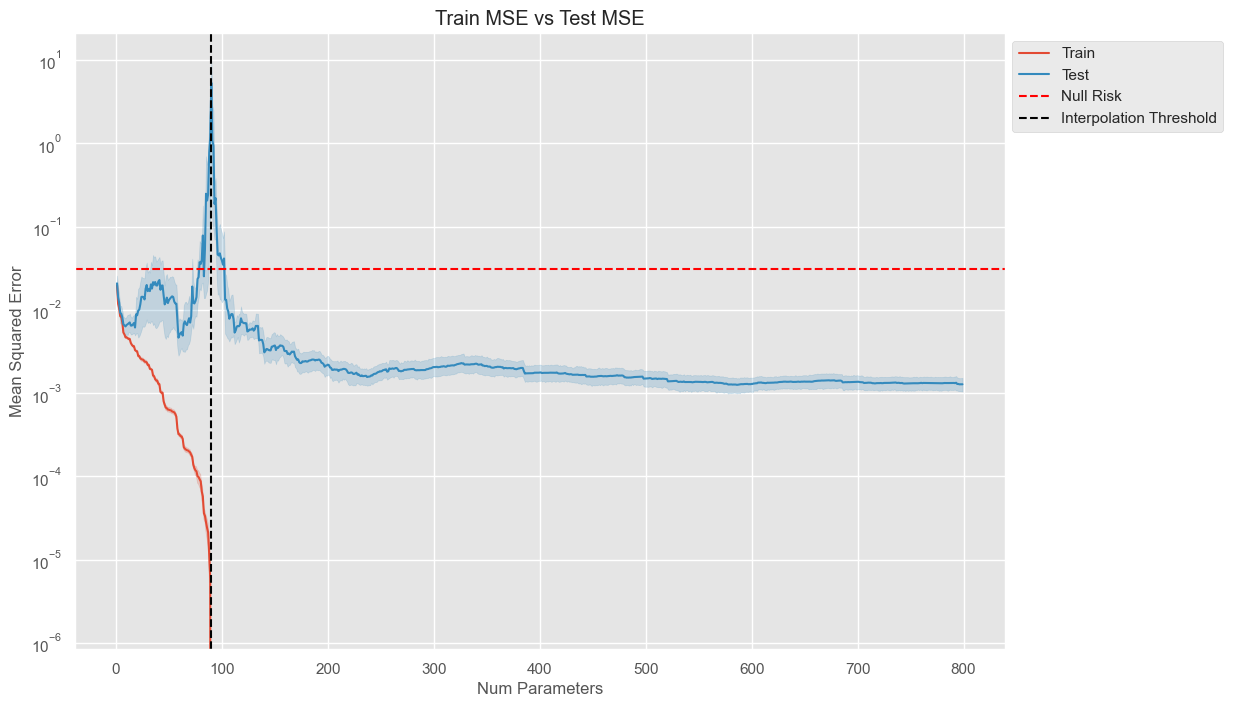

In [943]:
plot_MSE_DD(result_dfs_removed[1], null_risk=null_error_removed[1])

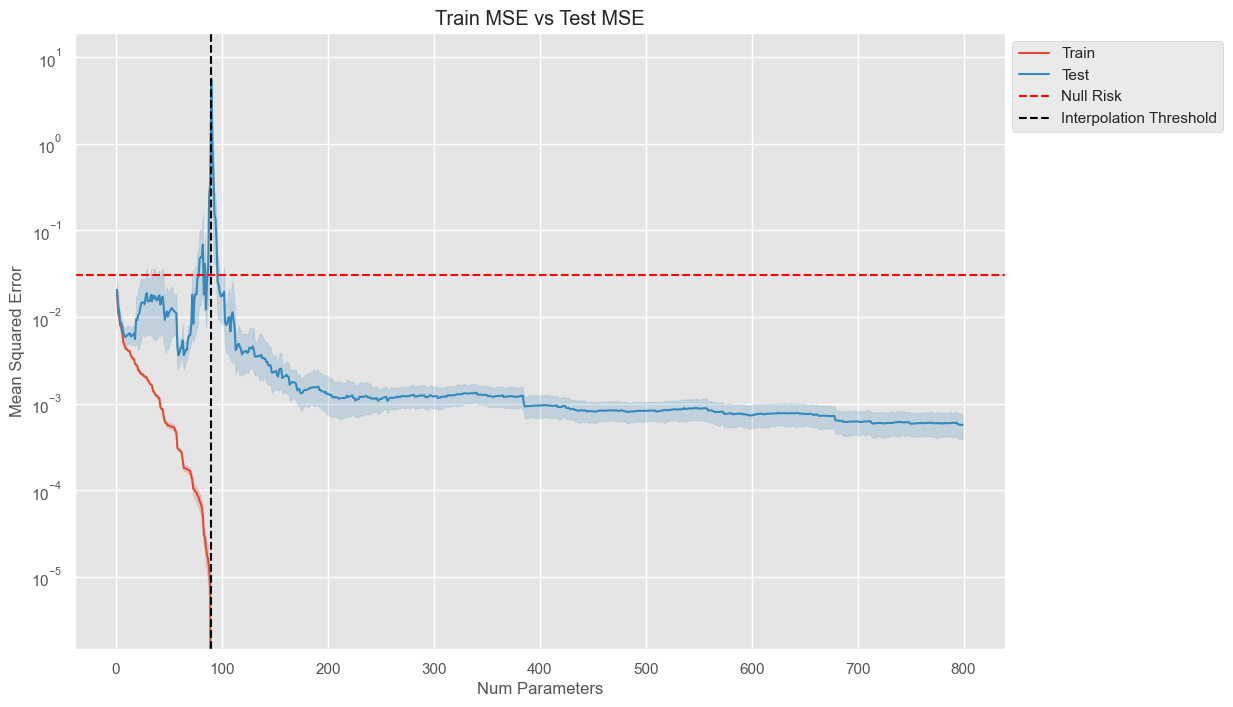

In [944]:
plot_MSE_DD(result_dfs_removed[2], null_risk=null_error_removed[2])

## Misspecified Models

A misspecified model is defined in the context of situations where the regression function is linear, but only a subset of the relevant features are observed. This setting highlights a scenario often encountered in real applications where the true form of the regression function is not fully known, leading to the generation of features that aim to improve the approximation of this function. As a result, increasing the number of features beyond the point of interpolation can decrease both bias and variance, providing a potential motivation for such feature interpolation.

In [773]:
# True Model
X_scaled_ranked.iloc[:, true_coefs != 0]

,PctNotSpeakEnglWell LandArea,PctImmigRec10 PctVacMore6Mos,medIncome_9,MedYrHousBuilt LemasPctOfficDrugUn,HousVacant MedYrHousBuilt,MedNumBR PctSameCity85,PctVacMore6Mos MedYrHousBuilt,pctUrban PctHousLess3BR,agePct12t21 MedNumBR,TotalPctDiv PersPerFam,...,PersPerOccupHous PctSameState85,PctKids2Par PersPerOwnOccHous,PctKids2Par PctLargHouseFam,PctRecImmig8 RentLowQ,PctSpeakEnglOnly MedRent,PctRecImmig10 MedYrHousBuilt,racepctblack PctSpeakEnglOnly,householdsize PctHousOwnOcc,PctHousOccup_8,medIncome PctSameCity85
0,-0.055825,-0.689497,0.771500,1.381173,1.253718,0.279935,-0.246368,0.609793,0.338101,0.252554,...,-0.618997,-0.531289,-0.604167,-0.405945,0.069595,-0.299133,-0.575191,-0.622024,-0.376736,-0.243360
1,-0.193437,-0.172600,0.675249,-0.332230,-0.307039,-1.124283,-0.298691,1.741233,-1.112100,0.511198,...,-1.431088,-1.095130,-0.666690,0.136254,0.117902,0.467743,-0.204808,-1.558215,-0.587963,-0.260997
2,-0.235780,-1.098592,0.646110,-0.332230,-0.405614,0.720474,-0.351015,-1.251608,0.551365,0.746329,...,-0.312149,-0.539104,-0.558542,-0.534023,-0.105959,-0.503633,1.269584,-0.617807,-0.560733,-0.163014
3,-0.204023,-0.281324,-0.018232,-0.332230,-0.405614,0.637873,0.360581,-1.215109,1.063201,0.887407,...,1.638059,0.584970,1.252936,-0.023844,2.533834,-0.258233,2.959957,3.367333,-0.064867,0.948773
4,-0.193437,-0.255525,0.488350,-0.332230,-0.379074,0.555272,1.625194,-0.627491,0.508712,-1.209017,...,0.052234,1.367614,-0.071877,-0.497023,0.256932,-0.421046,-0.576083,1.535012,-0.482112,0.516339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.222548,-0.714374,0.743681,-0.332230,-0.271654,0.197334,-0.271322,0.536797,0.721977,-0.471648,...,-0.958250,-0.156798,-0.784977,-0.034517,0.170922,0.410326,-0.306552,-0.281846,-0.512201,-0.159094
1990,-0.055825,-0.821255,0.577179,-0.332230,-0.281764,-1.124283,-1.083540,0.938276,-1.112100,0.988983,...,-2.015687,0.054792,1.731997,1.809813,0.036605,1.690812,0.474376,-0.343696,-0.596906,-1.293091
1991,0.346426,-0.545761,0.675249,1.841650,0.298307,-1.124283,-0.556283,1.157264,-1.112100,0.082320,...,-0.055560,-0.778345,-0.379422,-0.391714,-0.405226,-0.434418,0.014744,-0.865911,-0.075629,0.123751
1992,-0.087582,-0.088754,0.704201,0.084588,-0.325996,-1.124283,-0.977283,1.084268,-1.112100,-0.831868,...,-0.777712,0.195451,0.125831,1.081189,0.850752,-0.020698,-0.472554,-0.645218,-0.590350,0.219775


In [774]:
y_simulated

array([0.15497809, 0.26679424, 0.18260594, ..., 0.42305512, 0.0922533 ,
       0.43526097])

In [798]:
sampled_errors

array([0.20433918, 0.1852224 , 0.06529322, ..., 0.25486341, 0.17782205,
       0.25133897])

Now imagine we only have 5 columns from the true model at hand.

In [889]:
misspecified_models_X = X_scaled_ranked.iloc[:, np.random.choice(np.where(true_coefs != 0)[0], 2, replace=False)]

In [890]:
misspecified_models_X

,PctEmplManu PersPerOccupHous,TotalPctDiv PersPerFam
0,-0.893948,0.252554
1,-0.725098,0.511198
2,-0.320662,0.746329
3,0.956164,0.887407
4,1.674178,-1.209017
...,...,...
1989,-0.943799,-0.471648
1990,-0.909225,0.988983
1991,0.471324,0.082320
1992,-0.230609,-0.831868


In [891]:
# apply transformation
mis_X_hermite = hermite_transform(misspecified_models_X, 20)
mis_X_hermite_interaction = add_interaction_terms(mis_X_hermite)

In [892]:
mis_X_hermite_interaction

,PctEmplManu PersPerOccupHous,TotalPctDiv PersPerFam,PctEmplManu PersPerOccupHous_2,PctEmplManu PersPerOccupHous_3,PctEmplManu PersPerOccupHous_4,PctEmplManu PersPerOccupHous_5,PctEmplManu PersPerOccupHous_6,PctEmplManu PersPerOccupHous_7,PctEmplManu PersPerOccupHous_8,PctEmplManu PersPerOccupHous_9,...,TotalPctDiv PersPerFam_16 TotalPctDiv PersPerFam_17,TotalPctDiv PersPerFam_16 TotalPctDiv PersPerFam_18,TotalPctDiv PersPerFam_16 TotalPctDiv PersPerFam_19,TotalPctDiv PersPerFam_16 TotalPctDiv PersPerFam_20,TotalPctDiv PersPerFam_17 TotalPctDiv PersPerFam_18,TotalPctDiv PersPerFam_17 TotalPctDiv PersPerFam_19,TotalPctDiv PersPerFam_17 TotalPctDiv PersPerFam_20,TotalPctDiv PersPerFam_18 TotalPctDiv PersPerFam_19,TotalPctDiv PersPerFam_18 TotalPctDiv PersPerFam_20,TotalPctDiv PersPerFam_19 TotalPctDiv PersPerFam_20
0,-0.893948,0.252554,1.196570,5.012240,-16.140778,-11.239900,181.503542,-189.630528,-2202.010062,6971.051866,...,1.972144e+17,-4.063884e+16,-7.120244e+18,-2.052221e+18,-1.942876e+18,-3.404071e+20,-9.811328e+19,7.014575e+19,2.021764e+19,3.542290e+21
1,-0.725098,0.511198,0.103067,5.651315,-8.813916,-32.428615,135.166995,193.124798,-2172.406663,60.417868,...,-2.371355e+17,-1.166941e+19,-3.393881e+18,4.399678e+20,8.233672e+18,2.394645e+18,-3.104312e+20,1.178402e+20,-1.527629e+22,-4.442889e+21
2,-0.320662,0.746329,-1.588703,3.584172,7.233600,-33.312462,-50.971898,432.439075,436.272785,-7198.817635,...,1.096227e+18,-1.239904e+18,-4.131491e+19,-1.455263e+19,-1.606753e+19,-5.353869e+20,-1.885829e+20,6.055578e+20,2.132997e+20,7.107368e+21
3,0.956164,0.887407,1.656999,-4.480587,-18.510347,0.446835,185.957964,350.250631,-1933.617339,-9301.721033,...,-1.069895e+18,-4.510569e+18,3.051078e+19,2.255526e+20,6.282421e+19,-4.249610e+20,-3.141546e+21,-1.791593e+21,-1.324445e+22,8.958925e+22
4,1.674178,-1.209017,9.211487,17.449912,3.159593,-129.019851,-463.600299,-4.060544,6476.808041,21751.626565,...,-4.085456e+18,-1.717645e+19,1.886097e+20,1.966403e+20,8.818642e+19,-9.683498e+20,-1.009580e+21,-4.071225e+21,-4.244570e+21,4.660841e+22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.943799,-0.471648,1.563023,4.600031,-18.061142,-2.708089,185.723203,-318.073505,-1999.730214,8863.861016,...,6.091459e+17,-1.001527e+19,-1.248189e+19,3.923545e+20,-2.197153e+19,-2.738279e+19,8.607482e+20,4.502142e+20,-1.415199e+22,-1.763742e+22
1990,-0.909225,0.988983,1.306757,4.897525,-16.746442,-8.727649,183.335208,-228.653946,-2150.897357,7569.760429,...,-1.494248e+18,-1.912224e+19,1.596977e+19,7.582326e+20,6.009243e+19,-5.018566e+19,-2.382778e+21,-6.422377e+20,-3.049296e+22,2.546593e+22
1991,0.471324,0.082320,-1.111415,-4.818264,2.126566,40.550714,16.959377,-470.621854,-681.061899,6887.948218,...,6.491366e+17,-7.198673e+18,-2.455410e+19,2.695070e+20,-2.174777e+19,-7.417993e+19,8.142024e+20,8.226266e+20,-9.029188e+21,-3.079785e+22
1992,-0.230609,-0.831868,-1.787278,2.669197,9.492586,-25.731727,-83.057921,347.088538,1002.727408,-6015.892566,...,1.552980e+17,-3.058479e+17,-5.081877e+18,2.007712e+19,-3.401753e+19,-5.652251e+20,2.233051e+21,1.113169e+21,-4.397830e+21,-7.307302e+22


In [893]:
scaler = StandardScaler()
mis_X_scaled = scaler.fit_transform(mis_X_hermite_interaction)

In [897]:
alphas1, coefs1, _ = lasso_path(mis_X_scaled[:, 2:], y_simulated, eps=1e-5)

zero_alphas1 = np.zeros(coefs1.shape[0])

for i, coef in enumerate(coefs1):
    alpha_index = np.where(np.abs(coef) < zero_threshold)[0]
    if alpha_index.size > 0:
        zero_alphas1[i] = alphas1[np.max(alpha_index)]
    else:
        zero_alphas1[i] = np.inf  



In [898]:
feature_ranking1 = list(mis_X_hermite_interaction.columns[:2]) + list(mis_X_hermite_interaction.columns[np.argsort(-zero_alphas1)])

In [899]:
mis_X_scaled_df = pd.DataFrame(mis_X_scaled, columns= mis_X_hermite_interaction.columns)
mis_X_scaled_ranked = mis_X_scaled_df.loc[:, feature_ranking1]
mis_X_scaled_ranked.head()

,PctEmplManu PersPerOccupHous,TotalPctDiv PersPerFam,TotalPctDiv PersPerFam PctEmplManu PersPerOccupHous_19,PctEmplManu PersPerOccupHous_19,PctEmplManu PersPerOccupHous TotalPctDiv PersPerFam_20,PctEmplManu PersPerOccupHous_20,TotalPctDiv PersPerFam_19,TotalPctDiv PersPerFam_20,PctEmplManu PersPerOccupHous,PctEmplManu PersPerOccupHous PctEmplManu PersPerOccupHous_20,...,PctEmplManu PersPerOccupHous_18 TotalPctDiv PersPerFam_11,PctEmplManu PersPerOccupHous_11 PctEmplManu PersPerOccupHous_14,PctEmplManu PersPerOccupHous_2 TotalPctDiv PersPerFam_18,PctEmplManu PersPerOccupHous_18 TotalPctDiv PersPerFam_8,PctEmplManu PersPerOccupHous_11 PctEmplManu PersPerOccupHous_15,PctEmplManu PersPerOccupHous_18 TotalPctDiv PersPerFam_6,PctEmplManu PersPerOccupHous_18 TotalPctDiv PersPerFam_5,PctEmplManu PersPerOccupHous_18 TotalPctDiv PersPerFam_4,PctEmplManu PersPerOccupHous_11 TotalPctDiv PersPerFam_10,TotalPctDiv PersPerFam_18 TotalPctDiv PersPerFam_19
0,-0.893948,0.252554,-0.040185,-0.037373,0.032149,-0.036625,0.031079,0.031043,-0.893948,-0.036429,...,-0.002755,-0.036955,0.028745,-0.006076,-0.036511,-0.010260,0.016766,0.02965,-0.007590,-0.030748
1,-0.725098,0.511198,-0.040185,-0.037373,0.032388,-0.036625,0.031380,0.030620,-0.725098,-0.036429,...,-0.002755,-0.036955,0.028754,-0.006076,-0.036511,-0.010261,0.016766,0.02965,-0.007591,-0.030748
2,-0.320662,0.746329,-0.040185,-0.037372,0.032129,-0.036625,0.031733,0.031090,-0.320662,-0.036429,...,-0.002755,-0.036955,0.028726,-0.006076,-0.036511,-0.010261,0.016766,0.02965,-0.007588,-0.030748
3,0.956164,0.887407,-0.040185,-0.037372,0.032492,-0.036625,0.031650,0.031535,0.956164,-0.036429,...,-0.002755,-0.036955,0.028662,-0.006076,-0.036511,-0.010261,0.016766,0.02965,-0.007588,-0.030748
4,1.674178,-1.209017,-0.040185,-0.037372,0.032305,-0.036625,0.031912,0.031190,1.674178,-0.036429,...,-0.002756,-0.036955,0.028187,-0.006076,-0.036511,-0.010260,0.016766,0.02965,-0.007580,-0.030748


In [900]:
def misspecified_sample_DD(n, max_P, folds=10):
    n_samples = n

    random_indices = np.random.choice(mis_X_scaled_ranked.shape[0], size=n_samples, replace=False)

    X_sampled = mis_X_scaled_ranked.iloc[random_indices, :]
    y_sampled = y_simulated[random_indices]
    scores = sampled_errors[random_indices]
    
    P_sizes = np.arange(1, max_P, 1)
    result_df = run_DD_analysis(X_sampled, y_sampled, P_sizes, scores, folds)
    return result_df 

In [901]:
result_df_mis_20 = misspecified_sample_DD(100, 700)

Processed 100 features
Processed 200 features
Processed 300 features
Processed 400 features
Processed 500 features
Processed 600 features


In [885]:
tempX = mis_X_scaled_ranked.iloc[:100, :700]
tempy = y_simulated[:100]
tempXtest = mis_X_scaled_ranked.iloc[100:120, :700]
tempytest = y_simulated[100:120]
mean_squared_error(tempXtest @ np.linalg.pinv(tempX) @ tempy, tempytest)

7252756.990726811

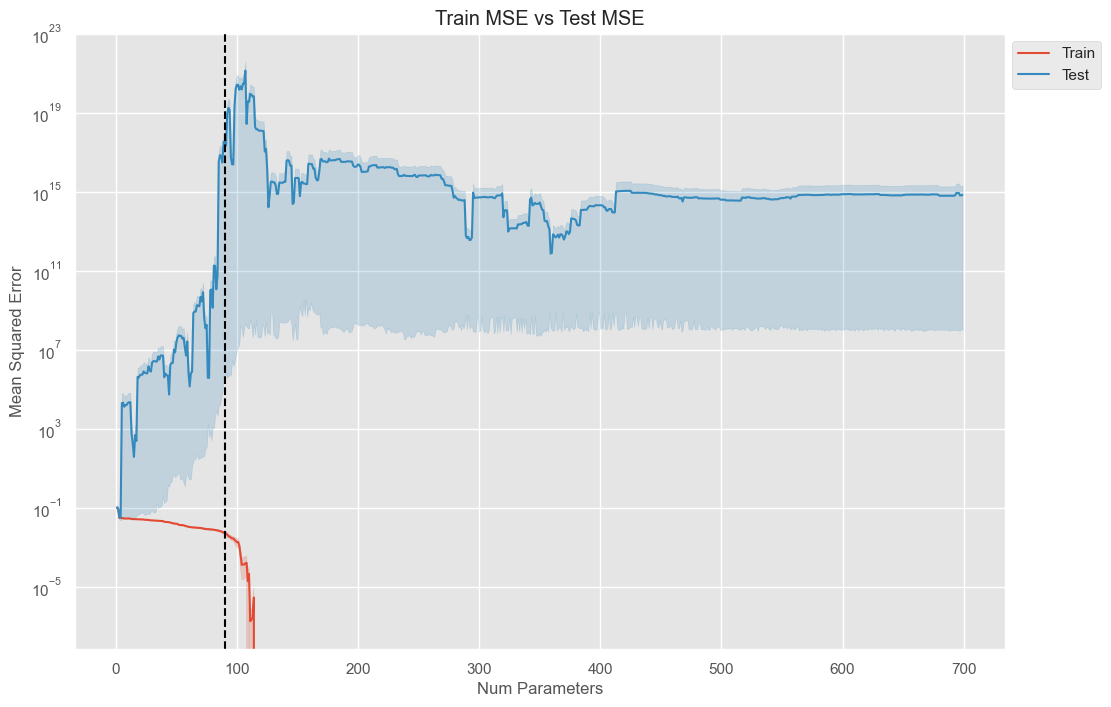

In [902]:
fig, ax = plt.subplots()
sns.lineplot(
    data=result_df_mis_20,
    x="P",
    y="Train MSE",
    label="Train",
    ax=ax,
)
sns.lineplot(
    data=result_df_mis_20,
    x="P",
    y="Test MSE",
    label="Test",
    ax=ax,
)
ax.set_xlabel("Num Parameters")
ax.set_ylabel("Mean Squared Error")
ax.axvline(x=100*0.9, color="black", linestyle="--", label="Interpolation Threshold")
ax.set_title(f"Train MSE vs Test MSE")
# ax.set_xscale("log")
ax.set_yscale("log")
sns.move_legend(obj=ax, loc="upper left", bbox_to_anchor=(1.0, 1.0))
  
